In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import scipy.stats as st
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
sns.set_theme(style="whitegrid")
sns.set_palette("Set2")

# What is the recipe for the perfect movie in **BOLLYWOOD** vs. in **HOLLYWOOD**?

## Data loading

### CMU dataset

| Column name          | Description                                                                                                                                                                                       |   |   |   |
|----------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|---|---|---|
| wikipedia_movie_id | ID of the movie from wikipedia                                                                                                                                                 |   |   |   |
| freebase_movie_id| ID of the movie from freebas                                                                                                                                            |   |   |   |
| movie_name | Name of the movie                                                                                                                                                |   |   |   |
| movie_release_date  | Date the movie was released                                                                                                                                      |   |   |   |
| movie_box_office_revenue  | Revenue of the movie box office                                                                                                                           
| movie_runtime  | Run time of the movie                                                                                                                                                 |   |   |   |
| movie_languages | Languages of the movie                                                                                                                                                  |   |   |   |
| movie_countries | Countries where the movie were created                                                                                                                                  |   |   |   |
| movie_genres   | Genre of the movie                                                                                                                                              |   |   |   |

The movie data set contains 81741 rows.



In [2]:
data_folder = './data/'

names = ['wikipedia_movie_id','freebase_movie_id', 'movie_name', 'movie_release_date', 'movie_box_office_revenue', 
        'movie_runtime', 'movie_languages', 'movie_countries', 'movie_genres']

movies_data = pd.read_csv(data_folder + 'movie.metadata.tsv', names = names, sep = '\t', )

movies_data[['movie_name', 'movie_languages', 'movie_countries', 'movie_genres']]= movies_data[['movie_name', 'movie_languages', 'movie_countries', 'movie_genres']].applymap(lambda x: str.lower(x))

movies_data.head()

,wikipedia_movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres
0,975900,/m/03vyhn,ghosts of mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""english language""}","{""/m/09c7w0"": ""united states of america""}","{""/m/01jfsb"": ""thriller"", ""/m/06n90"": ""science..."
1,3196793,/m/08yl5d,getting away with murder: the jonbenét ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""english language""}","{""/m/09c7w0"": ""united states of america""}","{""/m/02n4kr"": ""mystery"", ""/m/03bxz7"": ""biograp..."
2,28463795,/m/0crgdbh,brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""norwegian language""}","{""/m/05b4w"": ""norway""}","{""/m/0lsxr"": ""crime fiction"", ""/m/07s9rl0"": ""d..."
3,9363483,/m/0285_cd,white of the eye,1987,NaN,110.0,"{""/m/02h40lc"": ""english language""}","{""/m/07ssc"": ""united kingdom""}","{""/m/01jfsb"": ""thriller"", ""/m/0glj9q"": ""erotic..."
4,261236,/m/01mrr1,a woman in flames,1983,NaN,106.0,"{""/m/04306rv"": ""german language""}","{""/m/0345h"": ""germany""}","{""/m/07s9rl0"": ""drama""}"


### IMdb datasets (ratings, runtimes, isAdult)

In [3]:
#rating files loading
ratings = pd.read_csv(data_folder + 'title.ratings.tsv.gz', sep='\t', compression='gzip')
titles = pd.read_csv(data_folder + 'title.basics.tsv.gz', sep='\t', compression='gzip')

C:\Users\hugom\AppData\Local\Temp\ipykernel_18244\1642546411.py:3: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  titles = pd.read_csv(data_folder + 'title.basics.tsv.gz', sep='\t', compression='gzip')


## Preprocessing

### IMdb and CMU datasets merging

In [4]:
#merging IMdb dataset with title, isAdult and runtimeMinutes with dataset with averageRating on movie ID (tconst)
rates = titles.merge(ratings, how='left', on='tconst')[['averageRating', 'numVotes', 'originalTitle', 'isAdult', 'runtimeMinutes']]

#putting all titles to lower case to match the CMU dataset movie names and dropping column with upper cases
rates['movie_name'] = [ele.lower() for ele in rates['originalTitle'].astype(str)]
rates=rates.drop(columns='originalTitle')

#dropping all rows that have a movie name appearing multiple times so the merging on movie name with the CMU dataset is precise
rates = rates.drop_duplicates('movie_name', keep=False)

#converting runtimeMinutes to float and changing '\\N' to NaN to match the format in CMU dataset
rates['runtimeMinutes']=list(map(lambda x: float(x) if x!='\\N' else None , rates['runtimeMinutes']))

In [5]:
#merging CMU dataset with the IMdb dataset
movies_data_merged = movies_data.merge(rates, how = 'left', on='movie_name')

#completing the NaN values in movie_runtime of the CMU dataset with the available ones of the IMdb dataset.
#we trust more the CMU dataset than the IMdb one so we give priority to the runtime values of the CMU dataset
# to the IMdb ones and use the IMdb only if the value is missing in the CMU.
#finally we drop the column with the IMdb runtimes.
movies_data_merged.loc[movies_data_merged['movie_runtime'].isna(), 'movie_runtime']=movies_data_merged.loc[movies_data_merged['movie_runtime'].isna(), 'runtimeMinutes']
movies_data_merged=movies_data_merged.drop(columns='runtimeMinutes')

In [6]:
#finally creating the datasets with all indian movies and all american movies
indian_movies = movies_data_merged[movies_data_merged['movie_countries'] == '{"/m/03rk0": "india"}'].reset_index()
american_movies = movies_data_merged[movies_data_merged['movie_countries'] == '{"/m/09c7w0": "united states of america"}'].reset_index()

print('There are %d indian films and %d american films in the dataset' % (len(indian_movies), len(american_movies)))

There are 8240 indian films and 30300 american films in the dataset


## Asserting purity

In [7]:
print('wiki ID, indian: ', len(indian_movies.drop_duplicates('wikipedia_movie_id')), '\nfreebase ID, indian: ', len(indian_movies.drop_duplicates('freebase_movie_id')))
print('wiki ID, american: ', len(american_movies.drop_duplicates('wikipedia_movie_id')), '\nfreebase ID, american: ', len(american_movies.drop_duplicates('freebase_movie_id')))

wiki ID, indian:  8240 
freebase ID, indian:  8240
wiki ID, american:  30300 
freebase ID, american:  30300


Our indian and american movies data base both do not contain any duplicates on either wikipedia movie ID nor freebase ID.

## Missing values

In [8]:
indian_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8240 entries, 0 to 8239
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   index                     8240 non-null   int64  
 1   wikipedia_movie_id        8240 non-null   int64  
 2   freebase_movie_id         8240 non-null   object 
 3   movie_name                8240 non-null   object 
 4   movie_release_date        7599 non-null   object 
 5   movie_box_office_revenue  27 non-null     float64
 6   movie_runtime             4868 non-null   float64
 7   movie_languages           8240 non-null   object 
 8   movie_countries           8240 non-null   object 
 9   movie_genres              8240 non-null   object 
 10  averageRating             3369 non-null   float64
 11  numVotes                  3369 non-null   float64
 12  isAdult                   3955 non-null   object 
dtypes: float64(4), int64(2), object(7)
memory usage: 837.0+ KB


In [9]:
american_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30300 entries, 0 to 30299
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   index                     30300 non-null  int64  
 1   wikipedia_movie_id        30300 non-null  int64  
 2   freebase_movie_id         30300 non-null  object 
 3   movie_name                30300 non-null  object 
 4   movie_release_date        29181 non-null  object 
 5   movie_box_office_revenue  5484 non-null   float64
 6   movie_runtime             27313 non-null  float64
 7   movie_languages           30300 non-null  object 
 8   movie_countries           30300 non-null  object 
 9   movie_genres              30300 non-null  object 
 10  averageRating             10917 non-null  float64
 11  numVotes                  10917 non-null  float64
 12  isAdult                   12302 non-null  object 
dtypes: float64(4), int64(2), object(7)
memory usage: 3.0+ MB


We notice that the movie box office revenue is very often unavailable and present in very limited number in both datasets. Thus we probably won't use it for further analysis.

The informations merged from the IMdb dataset (averageRating, numVotes and isAdult) are available in almost the half of the dataset which makes them still usable despite an important loss of data points.

## Analysis of ratings

### Some global infos about ratings

In [10]:
print('%.3f percent of indian movies have a rating and %.3f percent of american movies have a rating' %
(100-np.sum(indian_movies['averageRating'].isna())/indian_movies.shape[0]*100, 100-np.sum(american_movies['averageRating'].isna())/american_movies.shape[0]*100))

print('Average rating of indian movies : %.3f \tAverage rating of american movies : %.3f' %
(np.mean(indian_movies['averageRating']), np.mean(american_movies['averageRating'])))

40.886 percent of indian movies have a rating and 36.030 percent of american movies have a rating
Average rating of indian movies : 6.243 	Average rating of american movies : 6.115


### Distributions of movie ratings

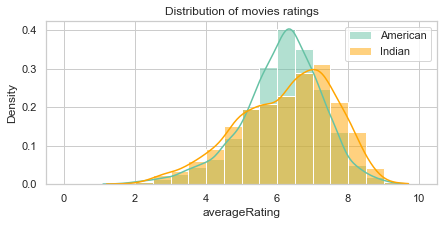

In [11]:
plt.figure(figsize=(7,3))
sns.histplot(x='averageRating', data=american_movies, alpha=0.5, label='American', stat = 'density', binrange=[0,10], bins = 20, kde=True)
sns.histplot(x='averageRating', data=indian_movies, alpha=0.5, color='orange', stat = 'density', label='Indian', binrange=[0,10], bins = 20, kde=True)
plt.title('Distribution of movies ratings')
plt.legend()
plt.show()

In [12]:
print('P-value for normality test of american ratings : %.10f \tP-value for normality test of indian ratings : %.10f ' 
      % (st.normaltest(american_movies['averageRating'], nan_policy='omit').pvalue, st.normaltest(indian_movies['averageRating'], nan_policy='omit').pvalue))

P-value for normality test of american ratings : 0.0000000000 	P-value for normality test of indian ratings : 0.0000000000 


Indian and american movies get similar distributions of ratings. This will allow us to use more easily the ratings as an unbiased tool to estimate the success of a movie.

### Distribution of number of votes

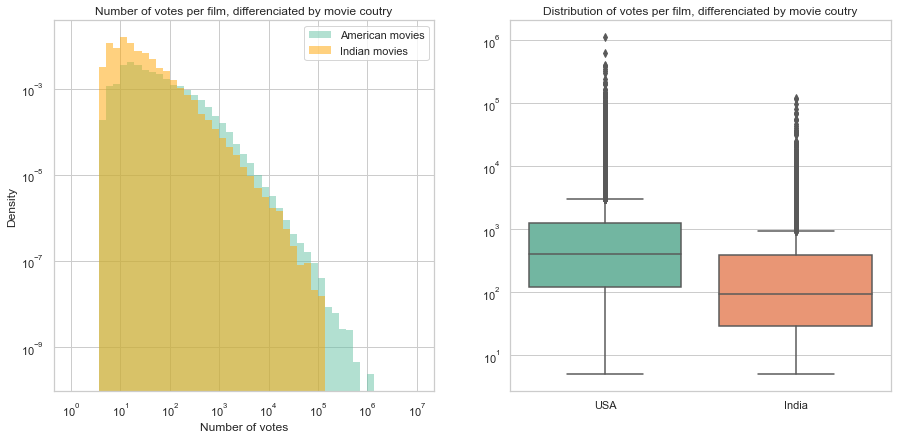

In [13]:
plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
sns.histplot(american_movies['numVotes'], bins=np.logspace(0,7,50), alpha =.5, binrange=[0., 1e7], stat = 'density')
sns.histplot(indian_movies['numVotes'], bins=np.logspace(0,7,50), alpha=.5, binrange=[0., 1e7], color = 'orange', stat = 'density')
plt.legend(labels=["American movies","Indian movies"])
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Number of votes')
plt.title('Number of votes per film, differenciated by movie coutry')

plt.subplot(2,2,2)
sns.boxplot(data = pd.DataFrame({'USA': american_movies['numVotes'], 'India': indian_movies['numVotes']}))
plt.yscale('log')
plt.title('Distribution of votes per film, differenciated by movie coutry')
plt.show()

In this plot we can see that the distributions follow similar patterns, except in the extrems. Proportionally, indian movies have more films with few votes (less than 100 votes), and, inversly, american movies have a movies that exceed the maximum number of votes any indian film obtains

In average, american films receive more votes, but Indian films receive enough votes so that we can deem their ratings reliable

### Centering the data around each means for further analysis

In [14]:
#center data on mean
indian_movies.loc[:,'centeredRating']=indian_movies['averageRating'].copy()-np.mean(indian_movies['averageRating'])
american_movies.loc[:,'centeredRating']=american_movies['averageRating'].copy()-np.mean(american_movies['averageRating'])
print('Centered average rating of indian movies : %.3f \tCentered average rating of american movies : %.3f' %
(np.mean(indian_movies['centeredRating']), np.mean(american_movies['centeredRating'])))

Centered average rating of indian movies : -0.000 	Centered average rating of american movies : -0.000


## Runtimes analysis

### Some global infos about runtimes

In [15]:
print('%.3f percent of indian movies have a runtime and %.3f percent of american movies have a runtime' %
(100-np.sum(indian_movies['movie_runtime'].isna())/indian_movies.shape[0]*100, 100-np.sum(american_movies['movie_runtime'].isna())/american_movies.shape[0]*100))

print('Average runtime of indian movies : %.3f \tAverage runtime of american movies : %.3f' %
(indian_movies['movie_runtime'].mean(), american_movies['movie_runtime'].mean()))


59.078 percent of indian movies have a runtime and 90.142 percent of american movies have a runtime
Average runtime of indian movies : 142.387 	Average runtime of american movies : 123.821


### Distribution of movie runtimes

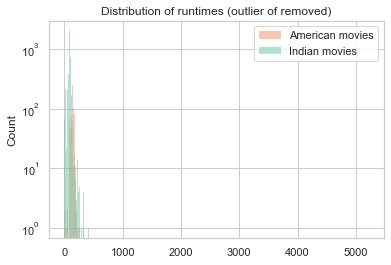

In [16]:
data_runtime = pd.DataFrame({'USA': american_movies.query('movie_runtime < 10000')['movie_runtime'], 'India': indian_movies.query('movie_runtime < 10000')['movie_runtime']})
sns.histplot(data = data_runtime)
plt.yscale('log')
plt.legend(labels=["American movies","Indian movies"])
plt.title(f'Distribution of runtimes (outlier of removed)')
plt.show()

From this plot we can see that we have a few outliers in both datasets. Looking at most of the films that are longer than 1000 minutes (16 hours), we decided that they could be discarted as they are either errors or not pertinent to our analysis (series of films instead of single film).

In [17]:
print('Number of films longer than 16 hours:', len(indian_movies.query('movie_runtime > 1000')) + len(american_movies.query('movie_runtime > 1000')))

Number of films longer than 16 hours: 8


Deleting 8 films that are very likely to be errors shouldn't make default to our analysis

In [18]:
# deleting films with runtime longer than 6 hours

indian_movies = indian_movies.query('movie_runtime < 1000')
american_movies = american_movies.query('movie_runtime < 1000')

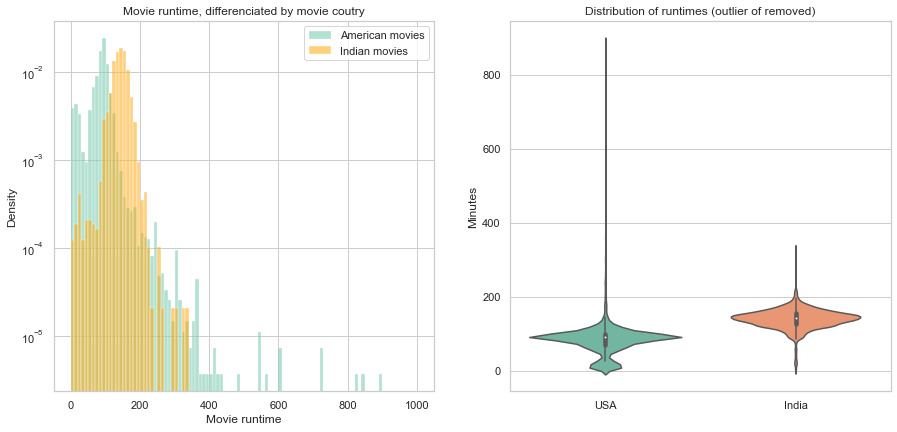

In [19]:
#defining number of bins to get roughly equal width between the 2 histograms
data_runtime = pd.DataFrame({'USA': american_movies['movie_runtime'], 'India': indian_movies['movie_runtime']})
#plotting
plt.figure(figsize=(15,15))

plt.subplot(2,2,1)
sns.histplot(american_movies['movie_runtime'], alpha =.5, stat = 'density', bins = 100, binrange= [0,1000])
sns.histplot(indian_movies['movie_runtime'], alpha=.5, color = 'orange', stat = 'density', bins = 100, binrange= [0,1000])
plt.yscale('log')
plt.legend(labels=["American movies","Indian movies"])
plt.xlabel('Movie runtime')
plt.title('Movie runtime, differenciated by movie coutry')


plt.subplot(2,2,2)
sns.violinplot(data = data_runtime)
plt.ylabel('Minutes')
plt.title(f'Distribution of runtimes (outlier of removed)')

plt.show()

In [20]:
print('median runtime difference:', np.nanmedian(american_movies['movie_runtime'] - indian_movies['movie_runtime']))

median runtime difference: -56.0


We notice that indian movies have a tendancy to be longer by ~56 minutes and that there are a lot of short american movies, perhaps the oldest films from the dataset.

There could thus be a bias in our dataset, because early indian cinema might be under-represneted compared to early american cinema. We will investigate this bias when differentiating with respects to time.

It would be interesting to further study the evolution of these tendancies through time and integrate runtime to our analysis. Do we tend to a global equilibrium in the runtimes between indian and american movies revealing a standardization?

## Numbers of Indian vs American movies per year

In [21]:
indian_movies_years = indian_movies.copy()

#slice the movie release date column to only have the years, and transform them as integer again
indian_movies_years['movie_release_date'] = indian_movies['movie_release_date'].dropna().astype('str').apply(lambda s: s[0:4]).astype('int')

#count the numbers of movies per year there are for indian movies
n_movie_per_year_indian = indian_movies_years.groupby('movie_release_date')['movie_name'].agg(['count'])

#change the movie release date as a column
n_movie_per_year_indian = pd.DataFrame(n_movie_per_year_indian).reset_index()

#sort the values
n_movie_per_year_indian['movie_release_date'] = n_movie_per_year_indian['movie_release_date'].sort_values()

n_movie_per_year_indian

,movie_release_date,count
0,1912.0,1
1,1913.0,1
2,1931.0,2
3,1932.0,1
4,1933.0,1
...,...,...
80,2010.0,168
81,2011.0,116
82,2012.0,132
83,2013.0,6


In [22]:
american_movies_years = american_movies.copy()

#slice the movie release date column to only have the years, and transform them as integer again
american_movies_years['movie_release_date'] = american_movies['movie_release_date'].dropna().astype('str').apply(lambda s: s[0:4]).astype('int')

#count the numbers of movies per year there are for american movies
n_movie_per_year_american = american_movies_years.groupby('movie_release_date')['movie_name'].agg(['count'])

#change the movie release date as a column
n_movie_per_year_american = pd.DataFrame(n_movie_per_year_american).reset_index()

#sort the values
n_movie_per_year_american['movie_release_date'] = n_movie_per_year_american['movie_release_date'].sort_values()

n_movie_per_year_american

,movie_release_date,count
0,1890.0,1
1,1891.0,1
2,1893.0,1
3,1894.0,9
4,1895.0,1
...,...,...
114,2009.0,685
115,2010.0,526
116,2011.0,407
117,2012.0,235


Let us slice the data to have the same time frame: from 1912 to 2014 for both Indian and American movies.

In [23]:
#Slice the data to have same time frame for both Indian and American movies data sets
n_movie_per_year_american = n_movie_per_year_american.query('movie_release_date <= 2014 & movie_release_date >= 1912')

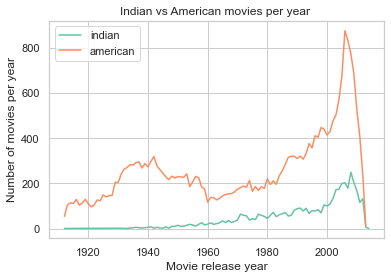

In [24]:
#Plot both Indian and American numbers of movies per year
sns.lineplot(data= n_movie_per_year_indian, x='movie_release_date', y = 'count', label='indian')
sns.lineplot(data= n_movie_per_year_american, x='movie_release_date', y = 'count', label='american')
plt.title('Indian vs American movies per year ')
plt.xlabel('Movie release year')
plt.ylabel('Number of movies per year')
plt.show()

We can observe a peak starting to grow from the 2000 years for both Hollywood and Bollywood movies.

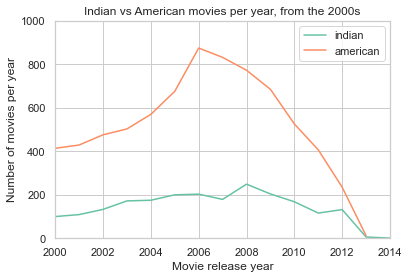

In [25]:
#Zoom in during the peak of Indian and American released movie years
sns.lineplot(data= n_movie_per_year_indian, x='movie_release_date', y = 'count', label='indian')
sns.lineplot(data= n_movie_per_year_american, x='movie_release_date', y = 'count', label='american')
plt.title('Indian vs American movies per year, from the 2000s')
plt.xlabel('Movie release year')
plt.ylabel('Number of movies per year')
plt.axis([2000, 2014, 0, 1000])
plt.show()

The peak of released movies are at 2006 for Hollywood and 2008 Bollywood respectively.

At 2014 it goes back to nearly 0 films released, but we should investigate carefully the data set that explain this lack of data.

Thus we begin the data set in 1950 for both Hollywood and Bollywood movies and cut the data set to 2006 for both Hollywood and Bollywood movies.


In [26]:
# transform the movie release date column to only have the years, and transform them as integer again
indian_movies['movie_release_date'] = indian_movies['movie_release_date'].dropna().astype('str').apply(lambda s: s[0:4]).astype('int')
american_movies['movie_release_date'] = american_movies['movie_release_date'].dropna().astype('str').apply(lambda s: s[0:4]).astype('int')

# Cut the data from 1950 to 2006 to have the same time frame for both Indian and American movies data sets
cut_american_movies = american_movies.query('movie_release_date <= 2006 & movie_release_date >= 1950')
cut_indian_movies = indian_movies.query('movie_release_date <= 2006 & movie_release_date >= 1950')

## Movie genre analysis

In [27]:
test_indian = indian_movies.copy()
#remove {}
test_indian['cleared_movie_genres'] = test_indian['movie_genres'].str[1:-1]
#remove films without genre
test_indian = test_indian.query("cleared_movie_genres != ''")

test_indian.head()

,index,wikipedia_movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,averageRating,numVotes,isAdult,centeredRating,cleared_movie_genres
2,31,9633533,/m/02pml15,vandanam,1989.0,NaN,168.0,"{""/m/0999q"": ""malayalam language""}","{""/m/03rk0"": ""india""}","{""/m/02kdv5l"": ""action""}",7.9,1197.0,0,1.65705,"""/m/02kdv5l"": ""action"""
3,35,29528534,/m/04j0lfk,anokha rishta,1986.0,NaN,180.0,"{""/m/03k50"": ""hindi language""}","{""/m/03rk0"": ""india""}","{""/m/03q4nz"": ""world cinema"", ""/m/04t36"": ""mus...",7.3,57.0,0,1.05705,"""/m/03q4nz"": ""world cinema"", ""/m/04t36"": ""musi..."
4,37,29772142,/m/0fq260_,karayilekku oru kadal dooram,2010.0,NaN,110.0,"{""/m/0999q"": ""malayalam language""}","{""/m/03rk0"": ""india""}","{""/m/07s9rl0"": ""drama""}",6.6,15.0,0,0.35705,"""/m/07s9rl0"": ""drama"""
6,55,36009421,/m/05b0lk8,jay vejay,1977.0,NaN,152.0,"{""/m/03k50"": ""hindi language""}","{""/m/03rk0"": ""india""}","{""/m/01hmnh"": ""fantasy"", ""/m/02kdv5l"": ""action...",NaN,NaN,NaN,NaN,"""/m/01hmnh"": ""fantasy"", ""/m/02kdv5l"": ""action""..."
9,80,24761154,/m/080bxrj,my friend ganesha,2007.0,NaN,190.0,"{""/m/03k50"": ""hindi language""}","{""/m/03rk0"": ""india""}","{""/m/03q4nz"": ""world cinema""}",4.8,214.0,0,-1.44295,"""/m/03q4nz"": ""world cinema"""


In [28]:
#create list with all genres and count each genre number of apparation
all_genres_listed_indian = test_indian['cleared_movie_genres'].str.split(pat=",")

ls = []
for i in all_genres_listed_indian:
    ls.extend(i)
 
all_genres_indian = pd.Series(ls)
all_genres_indian = all_genres_indian.str.strip().value_counts()
all_genres_indian.index = [ele.split(':')[1][2:-1] for ele in all_genres_indian.index]

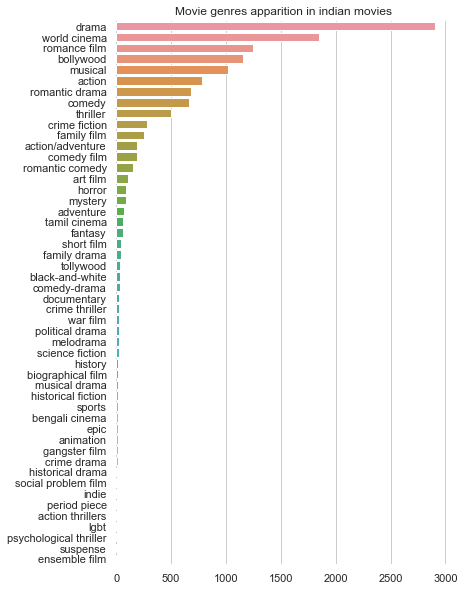

In [29]:
#ploting the first 50 genres
first_genres_indian = all_genres_indian[:50]
f, ax = plt.subplots(figsize=(6, 10))
sns.barplot(y = first_genres_indian.index, x = first_genres_indian).set_title('Movie genres apparition in indian movies')
sns.despine(left=True, bottom=True)

In [30]:
test_american = american_movies.copy()
#remove {}
test_american['cleared_movie_genres'] = test_american['movie_genres'].str[1:-1]
#remove films without genre
test_american = test_american.query("cleared_movie_genres != ''")
test_american.head()

,index,wikipedia_movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,averageRating,numVotes,isAdult,centeredRating,cleared_movie_genres
0,0,975900,/m/03vyhn,ghosts of mars,2001.0,14010832.0,98.0,"{""/m/02h40lc"": ""english language""}","{""/m/09c7w0"": ""united states of america""}","{""/m/01jfsb"": ""thriller"", ""/m/06n90"": ""science...",NaN,NaN,NaN,NaN,"""/m/01jfsb"": ""thriller"", ""/m/06n90"": ""science ..."
1,1,3196793,/m/08yl5d,getting away with murder: the jonbenét ramsey ...,2000.0,NaN,95.0,"{""/m/02h40lc"": ""english language""}","{""/m/09c7w0"": ""united states of america""}","{""/m/02n4kr"": ""mystery"", ""/m/03bxz7"": ""biograp...",NaN,NaN,NaN,NaN,"""/m/02n4kr"": ""mystery"", ""/m/03bxz7"": ""biograph..."
2,5,13696889,/m/03cfc81,the gangsters,1913.0,NaN,35.0,"{""/m/06ppq"": ""silent film"", ""/m/02h40lc"": ""eng...","{""/m/09c7w0"": ""united states of america""}","{""/m/02hmvc"": ""short film"", ""/m/06ppq"": ""silen...",NaN,NaN,NaN,NaN,"""/m/02hmvc"": ""short film"", ""/m/06ppq"": ""silent..."
3,7,10408933,/m/02qc0j7,alexander's ragtime band,1938.0,3600000.0,106.0,"{""/m/02h40lc"": ""english language""}","{""/m/09c7w0"": ""united states of america""}","{""/m/04t36"": ""musical"", ""/m/01z4y"": ""comedy"", ...",NaN,NaN,NaN,NaN,"""/m/04t36"": ""musical"", ""/m/01z4y"": ""comedy"", ""..."
4,10,175026,/m/017n1p,sarah and son,1930.0,NaN,86.0,"{""/m/02h40lc"": ""english language""}","{""/m/09c7w0"": ""united states of america""}","{""/m/07s9rl0"": ""drama"", ""/m/01g6gs"": ""black-an...",5.4,271.0,0,-0.715215,"""/m/07s9rl0"": ""drama"", ""/m/01g6gs"": ""black-and..."


In [31]:
#create list with all genres and count each genre number of apparation
all_genres_listed_american = test_american['cleared_movie_genres'].str.split(pat=",")

ls = []
for i in all_genres_listed_american:
    ls.extend(i)
 
all_genres_american = pd.Series(ls)
all_genres_american = all_genres_american.str.strip().value_counts()
all_genres_american.index=[ele.split(':')[1][2:-1] for ele in all_genres_american.index]

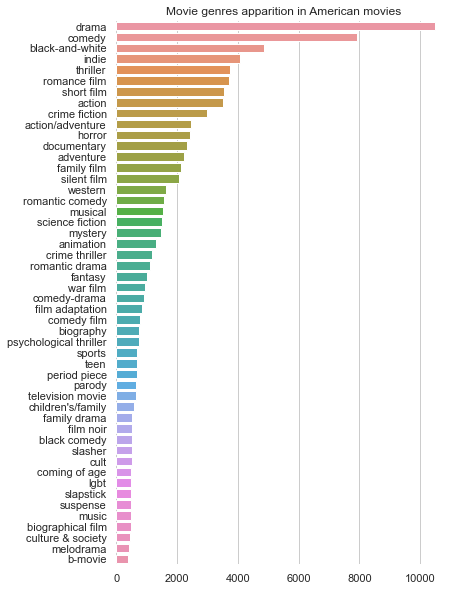

In [32]:
#ploting the first 50 genres
first_genres_american = all_genres_american[:50]
f, ax = plt.subplots(figsize=(6, 10))
sns.barplot(y = first_genres_american.index, x = first_genres_american).set_title('Movie genres apparition in American movies')
sns.despine(left=True, bottom=True)


To compare them with each other, we calculate the frequency of movie genre in each region

In [33]:
#calculate frequencies of movie genre in each production
all_genres_american_frequency = all_genres_american/len(american_movies)
first_genres_american_frequency = all_genres_american_frequency[:50]
all_genres_indian_frequency = all_genres_indian/len(indian_movies)
first_genres_indian_frequency = all_genres_indian_frequency[:50]

<AxesSubplot:title={'center':'India'}>

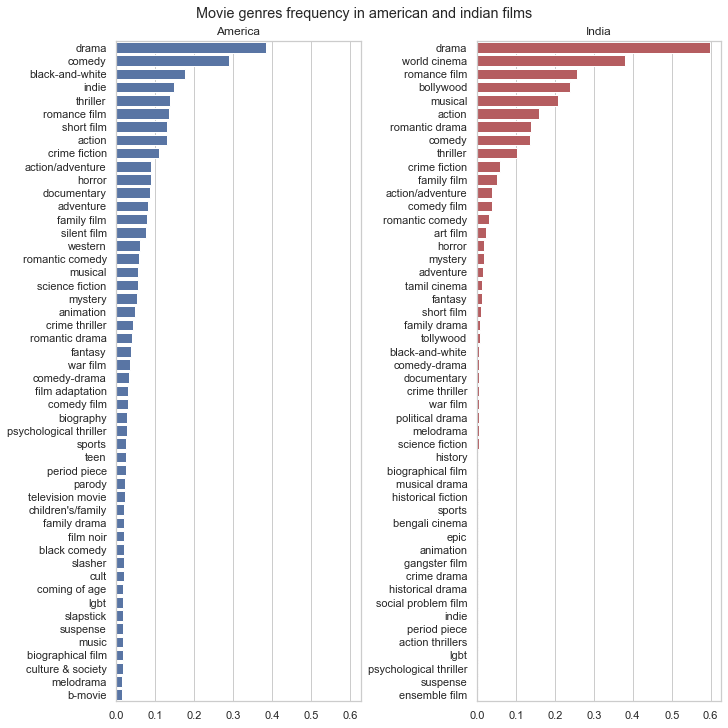

In [34]:
#ploting the first 50 genres
fig, ax = plt.subplots(1,2,figsize=(10, 10),sharex = True, constrained_layout=True)
fig.suptitle('Movie genres frequency in american and indian films')
ax[0].set_title('America')
ax[1].set_title('India')

sns.barplot(ax = ax[0],y = first_genres_american_frequency.index, x = first_genres_american_frequency, label="American", color="b")
sns.barplot(ax = ax[1], y = first_genres_indian_frequency.index, x = first_genres_indian_frequency, label="Indian", color="r")

In [35]:
print("Indian movies have a total of %d different movies genres and american have %d" %(len(all_genres_indian.index), len(all_genres_american.index)))

Indian movies have a total of 127 different movies genres and american have 328


As the plots show, "drama" is the prominent movie genre in both american and indian movies. However, american movies seems to have a better distribution of different genres than indian that are clearly more focused around "drama".

Furthermore, both of them have a large number of different movie genres which can make the analysis difficult. Moreover, genres like "silent film" or "world cinema" are not specific theme to categorize the movies. In the other hand, it seems that some genres are similar to each other or some of them include other genres (e.g. "action/aventure" can include "aventure"). In conclusion, for further analysis, it could be interesting to select a restricted group of movie genres that allows better and more precises results. 

### First analysis of movie genre across time

In [36]:
test_american['movie_release_date']

0        2001.0
1        2000.0
2        1913.0
3        1938.0
4        1930.0
          ...  
30295    1946.0
30296    1993.0
30297    1946.0
30298    2011.0
30299    1972.0
Name: movie_release_date, Length: 27246, dtype: float64

In [37]:
test_american = cut_american_movies.copy()
test_american = test_american.dropna(subset= 'movie_release_date')
test_american['movie_release_date'] = test_american['movie_release_date'].astype(str)
test_american['movie_release_date'] = test_american['movie_release_date'].str.slice(stop = 4)
test_american['cleared_movie_genres'] = test_american['movie_genres'].str[1:-1]
test_american = test_american.query("cleared_movie_genres != ''")
all_genre_american_time = pd.DataFrame(test_american['cleared_movie_genres'])
all_genre_american_time.index = test_american['movie_release_date'] 
all_genre_american_time = pd.DataFrame(all_genre_american_time.groupby(['movie_release_date'])['cleared_movie_genres'].apply(','.join).apply(lambda x: x.split(','))).explode('cleared_movie_genres')
all_genre_american_time['year'] = all_genre_american_time.index
all_genre_american_time['cleared_movie_genres']=[ele.split(':')[1][2:-1] for ele in all_genre_american_time['cleared_movie_genres']]

final = pd.crosstab(all_genre_american_time['year'], all_genre_american_time['cleared_movie_genres'])
#taking the first 30 genres
final = final[final.sum().sort_values(ascending= False)[:30].index]
#normalize by the number of genres per year
final = final.apply(lambda x: x/final.sum(axis = 1))

In [38]:
#plotting the 30 first prominent movie genres presence across time
#a, f = plt.subplots(figsize = (10,10), constrained_layout=True)
#plt.stackplot(final[70:].index, final[70:].to_dict(orient = 'list').values(), labels = final.keys())
#f.legend(loc='upper left')
#f.tick_params(axis = 'x', rotation = 90)
#a.suptitle("30 first prominent movie genres presence across time")

As we can see, there a too much genres to correctly analyze this plot. This encourages to select the main genres to analyze.

## Movie language

In this section, we will investigate some disparities or resemblence of the available languages of the film.

### Indian movies

In [39]:
indian_languages= indian_movies.copy()
#remove the {} in each rows
indian_languages['cleared_movie_languages'] = indian_languages['movie_languages'].str[1:-1]

#remove the films without any languages
indian_languages = indian_languages.query("cleared_movie_languages != ''")

In [40]:
#Create a list with all languages
all_languages_listed_indian = indian_languages['cleared_movie_languages'].str.split(pat=",")

#Drop the NAs
all_languages_listed_indian = all_languages_listed_indian.dropna()

#Create a list with all the languages in it
ls = []
for i in all_languages_listed_indian:
    ls.extend(i)
 
#Count the total number of languages that are in the movies for each one of the languages
all_languages_indian = pd.Series(ls)

#Strip the strings and count the numbers of occurence of each languages
all_languages_indian = all_languages_indian.str.strip().value_counts()

all_languages_indian.head()

"/m/03k50": "hindi language"        2369
"/m/07c9s": "tamil language"         970
"/m/09s02": "telugu language"        558
"/m/0999q": "malayalam language"     555
"/m/01c7y": "bengali language"       240
dtype: int64

In [41]:
all_languages_indian_code = all_languages_indian.copy()

#Put it as data frame
all_languages_indian_code= pd.DataFrame(all_languages_indian_code)

#Reset the index to have the index as column
all_languages_indian_code = all_languages_indian_code.reset_index()

#Rename the columns correctly
all_languages_indian_code = all_languages_indian_code.rename(columns={"index": "languages", 0:"count"})

#Remove the code part (that begins with "/m")
all_languages_indian_code['languages'] = all_languages_indian_code['languages'].apply(lambda s: re.sub(r'/m.+ "', '',s))

#Only take the top 20 languages to plot it 
top_20_ind = all_languages_indian_code.iloc[:20]

top_20_ind.head()

,languages,count
0,"""hindi language""",2369
1,"""tamil language""",970
2,"""telugu language""",558
3,"""malayalam language""",555
4,"""bengali language""",240


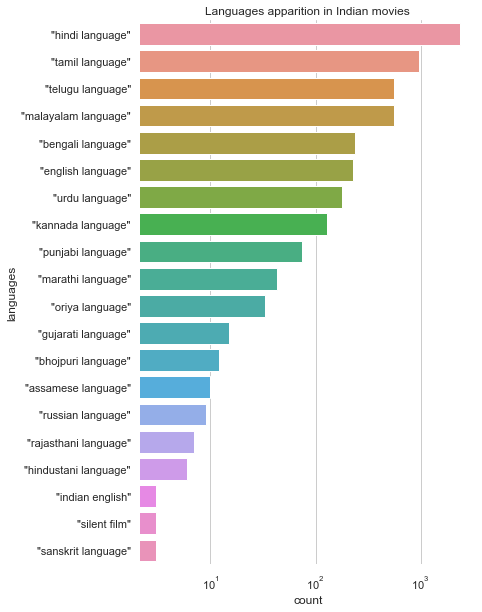

In [42]:
#Plotting top 20 languages (39 in total for indian languages)
f, ax = plt.subplots(figsize=(6, 10))
sns.barplot(data = top_20_ind,y = 'languages', x = 'count').set_title('Languages apparition in Indian movies')
ax.set_xscale('log')
sns.despine(left=True, bottom=True)

### American films

In [43]:
american_languages = american_movies.copy()
#Remove the {} in the column
american_languages['cleared_movie_languages'] = american_languages['movie_languages'].str[1:-1]

#Remove films without languages
american_languages = american_languages.query("cleared_movie_languages != ''")

In [44]:
#Create list with all languages
all_languages_listed_american = american_languages['cleared_movie_languages'].str.split(pat=",")

#Drop the NAs
all_languages_listed_american = all_languages_listed_american.dropna()

#Create a list with all the languages in it
ls = []
for i in all_languages_listed_american:
    ls.extend(i)
 
all_languages_american = pd.Series(ls)

#Count the total number of languages that are in the movies for each one of the languages
all_languages_american = all_languages_american.str.strip().value_counts()

all_languages_american.head()

"/m/02h40lc": "english language"    24506
"/m/06ppq": "silent film"            1436
"/m/06nm1": "spanish language"        412
"/m/064_8sq": "french language"       324
"/m/04306rv": "german language"       208
dtype: int64

In [45]:
all_languages_american_code =  all_languages_american.copy()

#Put it as data frame
all_languages_american_code = pd.DataFrame(all_languages_american_code)

#Reset the index to have the index as column
all_languages_american_code = all_languages_american_code.reset_index()

#Rename the columns correctly
all_languages_american_code = all_languages_american_code.rename(columns={"index": "languages", 0:"count"})

#Remove the code part (that begins with "/m")
all_languages_american_code['languages'] = all_languages_american_code['languages'].apply(lambda s: re.sub(r'/m.+ "', '',s))

#Only take the top 20 languages to plot it 
top_20_american = all_languages_american_code.iloc[:20]

top_20_american.head()

,languages,count
0,"""english language""",24506
1,"""silent film""",1436
2,"""spanish language""",412
3,"""french language""",324
4,"""german language""",208


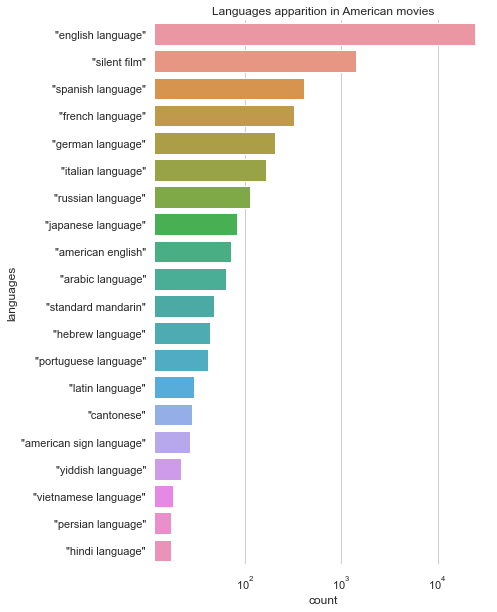

In [46]:
#Plotting top 20 languages (111 in total for American movies)
f, ax = plt.subplots(figsize=(6, 10))
sns.barplot(data = top_20_american, y = 'languages', x = 'count').set_title('Languages apparition in American movies')
ax.set_xscale('log')
sns.despine(left=True, bottom=True)

In [47]:
#Compute the frequency of top 20 for the American and Indian languages
all_languages_american_code['frequency'] = all_languages_american_code['count'] / all_languages_american_code['count'].sum()
first_languages_american_frequency = all_languages_american_code[:20]

all_languages_indian_code['frequency'] = all_languages_indian_code['count']/all_languages_indian_code['count'].sum()
first_languages_indian_frequency = all_languages_indian_code[:20]


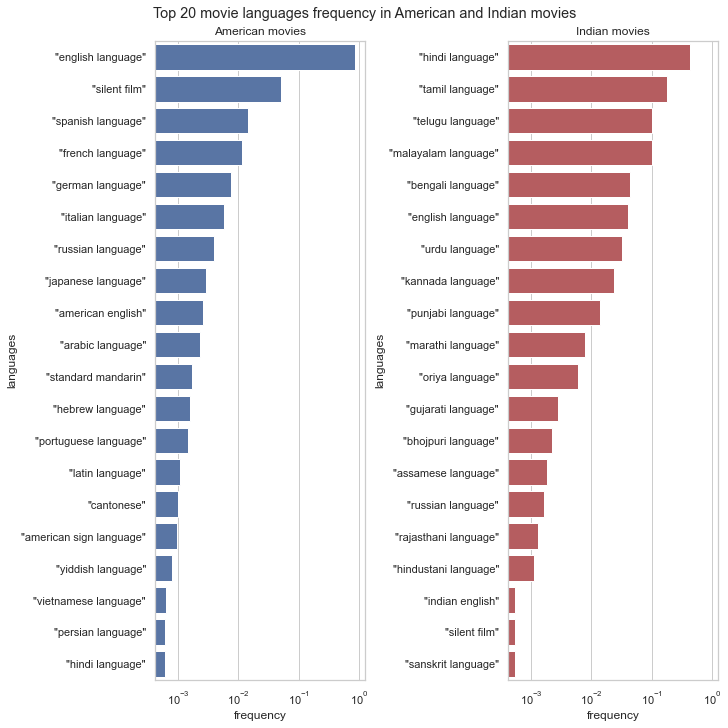

In [48]:
#Plotting taking the first 20 languages for American films and Indian movies
fig, ax = plt.subplots(1,2,figsize=(10, 10),sharex = True, constrained_layout=True)
fig.suptitle('Top 20 movie languages frequency in American and Indian movies')
ax[0].set_title('American movies')
ax[1].set_title('Indian movies')

sns.barplot(ax = ax[0],data = first_languages_american_frequency, y = 'languages', x = 'frequency', label="American", color="b")

sns.barplot(ax = ax[1], data = first_languages_indian_frequency, y = 'languages', x = 'frequency', label="Indian", color="r")

#Setting logarithmic scale 
ax[0].set_xscale('log')
ax[1].set_xscale('log')

### How many languages per movies there are, on average ?


In [49]:
#Compute the number of ':' that represent the number of languages there are in each row for American movies
american_languages['n_languages'] = american_languages.cleared_movie_languages.str.count(':')

#Compute the number of ':' that represent the number of languages there are in each row for Indian movies
indian_languages['n_languages'] = indian_languages.cleared_movie_languages.str.count(':')

In [50]:
#Drop the movies that do not have any languages
n_indian_lan = indian_languages['n_languages'].dropna()

n_american_lan = american_languages['n_languages'].dropna()

#Compute the t-test to compare the number of available languages per movies for Indian and American movies
t_test_languages = st.ttest_ind(n_indian_lan, n_american_lan)

t_test_languages.pvalue

print('p-value for languages: ',t_test_languages.pvalue, '\t', 'p-value is smaller than 0.05: ', t_test_languages.pvalue <0.05)

p-value for languages:  0.010952043619302956 	 p-value is smaller than 0.05:  True


There is a significant difference of the numbers of languages spoken in American vs Indian movies, so it could be that there are underlying effects, like Hollywood are more exported abroad than Bollywood movies.

## Characters data

450'668 characters in raw data

134079 differents actor 

5794 differents actor in indian movies

59398 differents actors in american movies


In [51]:
names = ['wikipedia_movie_id', 'freebase_movie_id', 'movie_release_date', 'character_name', 'actor_dob', 'actor_gender', 'actor_height', 'actor_ethnicity', 'actor_name', 'actor_age_at_movie_release', 'char_act_id', 'freebase_character_id', 'freebase_actor_id']
characters_data = pd.read_csv(data_folder + 'character.metadata.tsv', names = names, sep = '\t')

characters_data.head(10)

,wikipedia_movie_id,freebase_movie_id,movie_release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_movie_release,char_act_id,freebase_character_id,freebase_actor_id
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg
5,975900,/m/03vyhn,2001-08-24,Commander Helena Braddock,1949-05-26,F,1.727,/m/0x67,Pam Grier,52.0,/m/02vdcfp,/m/0bgchnd,/m/0418ft
6,975900,/m/03vyhn,2001-08-24,Whitlock,1945-08-02,F,1.753,NaN,Joanna Cassidy,56.0,/m/02vd6kw,/m/0bgchmx,/m/06lj1m
7,975900,/m/03vyhn,2001-08-24,Big Daddy Mars,NaN,M,NaN,NaN,Richard Cetrone,NaN,/m/0bgchsy,/m/0bgcht0,/m/0bgcht7
8,975900,/m/03vyhn,2001-08-24,Michael Descanso,1971-03-20,M,1.892,NaN,Liam Waite,30.0,/m/03jqhb0,/m/0bgchs4,/m/0ks8b0
9,975900,/m/03vyhn,2001-08-24,Uno,NaN,M,NaN,NaN,Duane Davis,NaN,/m/0bgchtj,/m/0bgchtm,/m/03nrwdy


In [52]:
# Putting every name in lower case
characters_data[['character_name', 'actor_name']] = characters_data[['character_name', 'actor_name']].applymap(lambda x: x if type(x)!=str else x.lower())

## Including ethnicities

Using the automatic query system from wikidata, we are able to retrieve the ethnicity of the actors based on the freebase ID in the actor_ethnicity column. For that we just map the matching id to the string-representation of the ethnicity for clarity

In [53]:
actor_ethnicities = pd.read_csv('data/ethnicities.csv.csv')[['freebaseID', 'name']]
actor_ethnicities = dict(zip(actor_ethnicities.freebaseID, actor_ethnicities.name))
characters_data['actor_ethnicity'] = characters_data['actor_ethnicity'].map(actor_ethnicities)

In [54]:
# We split the dataset in two
# all_american_actors can contain duplicate actors, it deals with the films 
# and who plays in it, the age they have when the film is produced
#
# all_indian_actors contains data about individual actors, it doesn't contain duplicates

all_american_actors = characters_data[characters_data['wikipedia_movie_id'].isin(american_movies['wikipedia_movie_id'])]
all_indian_actors = characters_data[characters_data['wikipedia_movie_id'].isin(indian_movies['wikipedia_movie_id'])]

unique_american_actor = all_american_actors.drop_duplicates('actor_name')
unique_indian_actor = all_indian_actors.drop_duplicates('actor_name')

In [55]:
# We add a column indicating the country the actor/actress works in before concatenating the datasets
unique_american_actor = unique_american_actor.assign(country = np.full(len(unique_american_actor), 'USA'))
unique_indian_actor = unique_indian_actor.assign(country = np.full(len(unique_indian_actor), 'India'))

all_american_actors = all_american_actors.assign(country = np.full(len(all_american_actors), 'USA'))
all_indian_actors = all_indian_actors.assign(country = np.full(len(all_indian_actors), 'India'))


#unique_indian_actor['country'] = np.full(len(unique_indian_actor), 'India')

# We make sure to only keep actors with positive age to get rid of the errors 
all_american_actors = all_american_actors[all_american_actors['actor_age_at_movie_release'] > 0.]
all_indian_actors = all_indian_actors[all_indian_actors['actor_age_at_movie_release'] > 0.]

feature_list_all_actors = ['actor_gender', 'actor_age_at_movie_release', 'country']
all_actors_merged = pd.concat([all_american_actors[feature_list_all_actors], all_indian_actors[feature_list_all_actors]], axis = 0)

feature_list_unique_actors = ['actor_name', 'actor_gender', 'actor_ethnicity', 'country']
unique_actors_merged = pd.concat([unique_american_actor[feature_list_unique_actors], unique_indian_actor[feature_list_unique_actors]], axis = 0)

# Adding a column to the dataset of the features of single actors for the number of films in our dataset they appear in
dict_number_of_film = characters_data['actor_name'].value_counts().to_dict()
unique_actors_merged['number_of_films'] = unique_actors_merged['actor_name'].map(dict_number_of_film)

In [56]:
all_actors_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 155912 entries, 0 to 450590
Data columns (total 3 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   actor_gender                155220 non-null  object 
 1   actor_age_at_movie_release  155912 non-null  float64
 2   country                     155912 non-null  object 
dtypes: float64(1), object(2)
memory usage: 4.8+ MB


In [57]:
unique_actors_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62902 entries, 0 to 450253
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   actor_name       62900 non-null  object 
 1   actor_gender     48210 non-null  object 
 2   actor_ethnicity  2284 non-null   object 
 3   country          62902 non-null  object 
 4   number_of_films  62900 non-null  float64
dtypes: float64(1), object(4)
memory usage: 2.9+ MB


## Actor Age

To do analysis on age, it makes sense to count the same actors multiple times as they play in different films, we will thus not drop the duplicates for this part of the analysis

In [58]:
print(all_american_actors.actor_age_at_movie_release.describe())
print(all_indian_actors.actor_age_at_movie_release.describe())

count    133511.000000
mean         37.651474
std          14.290871
min           1.000000
25%          28.000000
50%          36.000000
75%          46.000000
max         103.000000
Name: actor_age_at_movie_release, dtype: float64
count    22401.000000
mean        36.846971
std         13.328563
min          1.000000
25%         26.000000
50%         35.000000
75%         46.000000
max         95.000000
Name: actor_age_at_movie_release, dtype: float64


We can see that the mean age is similar in both cases, as well as the standard deviation. Looking at the different quartiles we cannot see significant distribution difference between the two groups. 

We can note, however, that we have significantly more available ages available for actors in american films as for actors in indian films (137'073 versus 31'201)

In [59]:
st.ttest_ind(all_american_actors.actor_age_at_movie_release, all_indian_actors.actor_age_at_movie_release, equal_var=False)

Ttest_indResult(statistic=8.271393615201204, pvalue=1.3752470963523454e-16)

We can reject the null hypothesis, that is, that the mean actor age from american and indian movies are the same

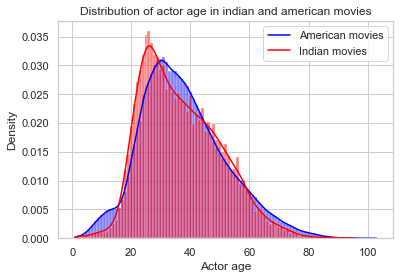

In [60]:
sns.histplot(data = all_american_actors['actor_age_at_movie_release'], stat = 'density', discrete=True, color = 'blue', kde=True)
sns.histplot(data = all_indian_actors['actor_age_at_movie_release'], stat = 'density',discrete=True, color='red', kde=True)
plt.legend(labels=["American movies","Indian movies"])
plt.xlabel('Actor age')
plt.title('Distribution of actor age in indian and american movies')
plt.show()


There seems to be more teenagers cast in american films, this can be due to the popularity of 'teen movies' in the western world, but is more likely to be simply due to a bias in quantity of information about american movies. The wikipedia pages of american movies might be more detailed about american films, containing even information about characters that may have relatively low screen time, like the daughter of a secondary character etc..

Otherwise the distributions seem similar

## Actor Gender

In [61]:
# We separate the datasets containing all actors by gender
# For american films
american_film_female = all_american_actors[all_american_actors['actor_gender'] == 'F']
american_film_male = all_american_actors[all_american_actors['actor_gender'] == 'M']

# And for indian films
indian_film_female = all_indian_actors[all_indian_actors['actor_gender'] == 'F']
indian_film_male = all_indian_actors[all_indian_actors['actor_gender'] == 'M']


In [62]:
print('Number of american film actors we have the gender of is {0}, of which {1:.0%} are female'.format(
    len(american_film_male) + len(american_film_female), len(american_film_female)/(len(american_film_male) + len(american_film_female))))

print('Number of indian film actors we have the gender of is {0}, of which {1:.0%} are female'.format(
    len(indian_film_male) + len(indian_film_female), len(indian_film_female)/(len(indian_film_male) + len(indian_film_female))))

Number of american film actors we have the gender of is 132847, of which 34% are female
Number of indian film actors we have the gender of is 22373, of which 36% are female


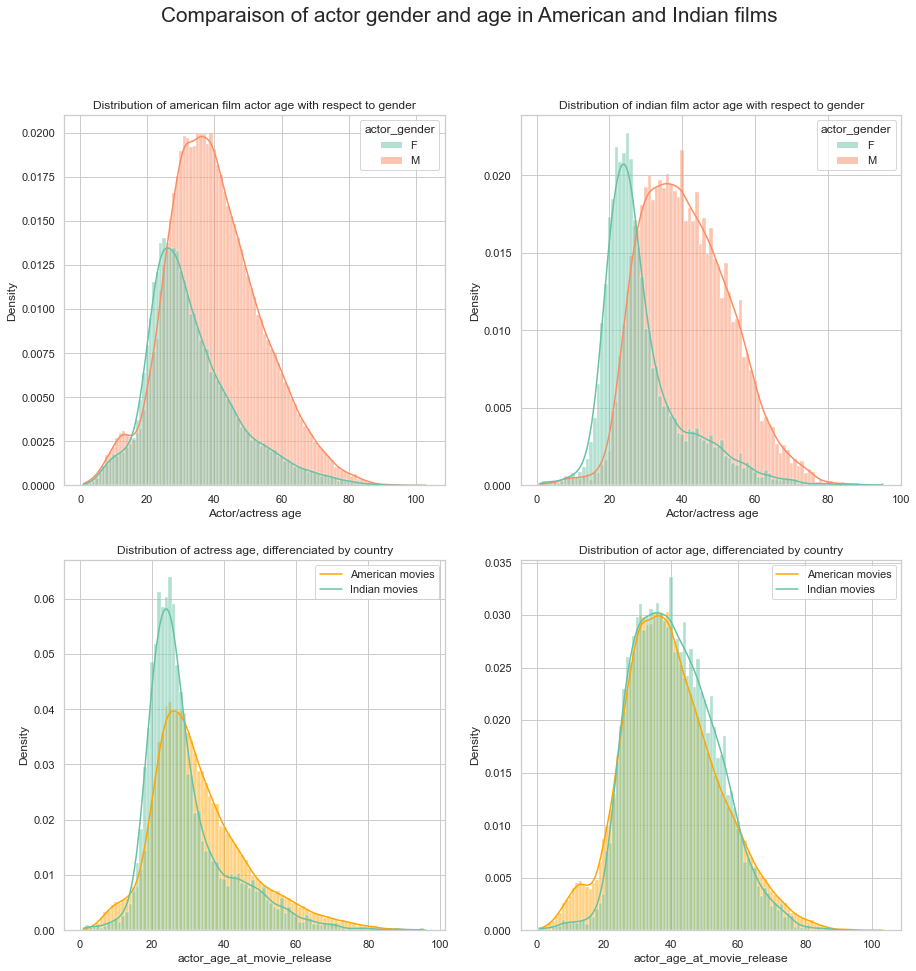

In [63]:
plt.figure(figsize=(15,15))
plt.suptitle('Comparaison of actor gender and age in American and Indian films', size = 'xx-large')
plt.subplot(2,2,1)

sns.histplot(data = all_american_actors, x = 'actor_age_at_movie_release', hue = 'actor_gender', stat = 'density', discrete=True, kde=True)
plt.xlabel('Actor/actress age')
plt.title('Distribution of american film actor age with respect to gender')

plt.subplot(2,2,2)
sns.histplot(data = all_indian_actors, x = 'actor_age_at_movie_release', hue = 'actor_gender', stat = 'density', discrete=True, kde=True)

plt.xlabel('Actor/actress age')
plt.title('Distribution of indian film actor age with respect to gender')

plt.subplot(2,2,3)
sns.histplot(data = all_american_actors[all_american_actors['actor_gender'] == 'F'], x = 'actor_age_at_movie_release', stat = 'density', discrete=True, color='orange', kde=True)
sns.histplot(data = all_indian_actors[all_indian_actors['actor_gender'] == 'F'], x = 'actor_age_at_movie_release', stat = 'density', discrete=True, kde=True)
plt.legend(labels=["American movies","Indian movies"])
plt.title('Distribution of actress age, differenciated by country')

plt.subplot(2,2,4)
sns.histplot(data = all_american_actors[all_american_actors['actor_gender'] == 'M'], x = 'actor_age_at_movie_release', stat = 'density', discrete=True, color='orange', kde=True)
sns.histplot(data = all_indian_actors[all_indian_actors['actor_gender'] == 'M'], x = 'actor_age_at_movie_release', stat = 'density', discrete=True, kde=True)
plt.legend(labels=["American movies","Indian movies"])
plt.title('Distribution of actor age, differenciated by country')


plt.show()


We can also visualize the same phenomenon using boxplots

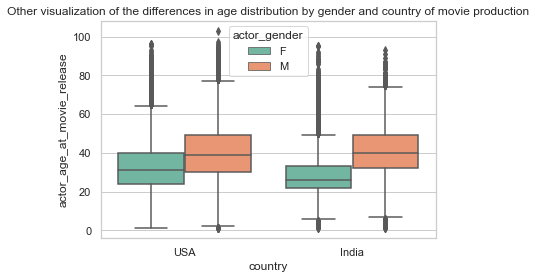

In [64]:
sns.boxplot(data = all_actors_merged, y = 'actor_age_at_movie_release', x = 'country', hue= 'actor_gender')
plt.title('Other visualization of the differences in age distribution by gender and country of movie production')
plt.show()

There are very little differences between the distributions of actor age between the two movie industries, but a big difference between the distribution of actresses' age. We can see that in indian movies there is a big density peak in the low twenties and a rapid decline from the thirties onward. 

This difference is very stark and should be investigated further in the rest of our analysis, regarding time-wise changes and the prediction of movie success.

We can evaluate the significance of the difference between the mean age of actors and actresses

In [65]:
print(st.ttest_ind(all_american_actors.loc[all_american_actors.actor_gender == 'F']['actor_age_at_movie_release'],all_american_actors.loc[all_american_actors.actor_gender == 'M']['actor_age_at_movie_release']))
print(st.ttest_ind(all_indian_actors.loc[all_indian_actors.actor_gender == 'F']['actor_age_at_movie_release'],all_indian_actors.loc[all_indian_actors.actor_gender == 'M']['actor_age_at_movie_release']))
print(st.ttest_ind(all_american_actors.loc[all_american_actors.actor_gender == 'F']['actor_age_at_movie_release'],all_indian_actors.loc[all_indian_actors.actor_gender == 'F']['actor_age_at_movie_release']))
print(st.ttest_ind(all_american_actors.loc[all_american_actors.actor_gender == 'M']['actor_age_at_movie_release'],all_indian_actors.loc[all_indian_actors.actor_gender == 'M']['actor_age_at_movie_release']))

Ttest_indResult(statistic=-83.375837797232, pvalue=0.0)
Ttest_indResult(statistic=-69.9101009397103, pvalue=0.0)
Ttest_indResult(statistic=24.642770642505056, pvalue=2.4837496028152856e-133)
Ttest_indResult(statistic=-8.752158873446778, pvalue=2.1241346763315404e-18)


All null hypotheses can be rejected at the alpha = 0.05 level, although the effects might mainly be driven by sample size 

## Number of films actors played in

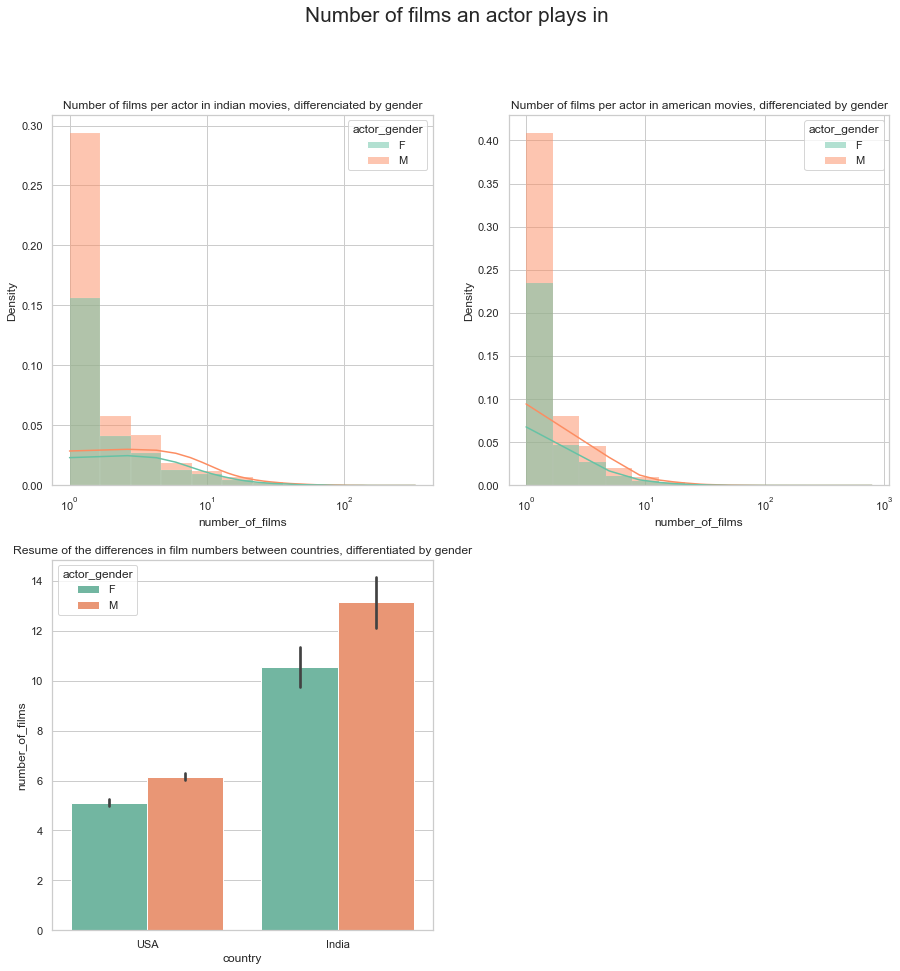

In [66]:
plt.figure(figsize=(15,15))
plt.suptitle('Number of films an actor plays in', size = 'xx-large')
plt.subplot(2,2,1)
sns.histplot(data = unique_actors_merged[unique_actors_merged['country'] == 'India'], bins = np.logspace(0,2, 10), x = 'number_of_films', hue = 'actor_gender', kde = True, stat = 'density').set(xscale="log")
plt.title('Number of films per actor in indian movies, differenciated by gender')
plt.subplot(2,2,2)
sns.histplot(data = unique_actors_merged[unique_actors_merged['country'] == 'USA'], bins = np.logspace(0,2, 10), x = 'number_of_films', hue = 'actor_gender', kde = True, stat = 'density').set(xscale="log")
plt.title('Number of films per actor in american movies, differenciated by gender')

plt.subplot(2,2,3)
sns.barplot(data = unique_actors_merged, y = 'number_of_films', x = 'country', hue= 'actor_gender')
plt.title('Resume of the differences in film numbers between countries, differentiated by gender')
plt.show()

In [67]:
# counting the number of actors/actresses
unique_actors_merged[unique_actors_merged['number_of_films'] > 100].groupby(['country', 'actor_gender']).agg({'count'})

actor_name actor_ethnicity number_of_films
                          count           count           count
country actor_gender                                           
India   F                     5               1               5
        M                    45              15              45
USA     F                     2               0               2
        M                    32              10              32

We probably have a bias in our dataset in the quantity of information we have in our dataset regarding the american films. We are far more likely to have the names of actors that make a single brief aparition in an american film. However regarding the other extreme, we can see that there a lot more ultra-prolific indian film actors than american film actors.

In both film industries we see however that most of the hyper-prolific actors are males, which is probably linked to the difference in carreer prospects with age.

This is once again a angle that could be included in further analysis regarding trends through time and film succes (ratings) prediction

## Actor ethnicity

In [68]:
ethnicity_data = unique_actors_merged.groupby(['actor_ethnicity', 'country'], as_index=False)['actor_name'].agg({'count'})
ethnicity_data = pd.DataFrame(ethnicity_data.to_records())
ethnicity_data = ethnicity_data.set_index('actor_ethnicity')

#separate the dataset per country
ethnicity_data_india = ethnicity_data[ethnicity_data['country'] == 'India']
ethnicity_data_usa = ethnicity_data[ethnicity_data['country'] == 'USA']

# converting count into density
ethnicity_data_india['count'] = ethnicity_data_india.loc[:,'count'].div(len(ethnicity_data_india)).copy(deep=True)
ethnicity_data_usa['count'] = ethnicity_data_usa.loc[:,'count'].div(len(ethnicity_data_usa)).copy(deep=True)

ethnicity_data.head()

C:\Users\hugom\AppData\Local\Temp\ipykernel_18244\55783346.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ethnicity_data_india['count'] = ethnicity_data_india.loc[:,'count'].div(len(ethnicity_data_india)).copy(deep=True)
C:\Users\hugom\AppData\Local\Temp\ipykernel_18244\55783346.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ethnicity_data_usa['count'] = ethnicity_data_usa.loc[:,'count'].div(len(ethnicity_data_usa)).copy(deep=True)


,country,count
actor_ethnicity,,
Acadians,USA,1
Afghans in India,India,5
Afrikaners,USA,1
Afro Trinidadians and Tobagonians,USA,2
Afro-Cuban,USA,1


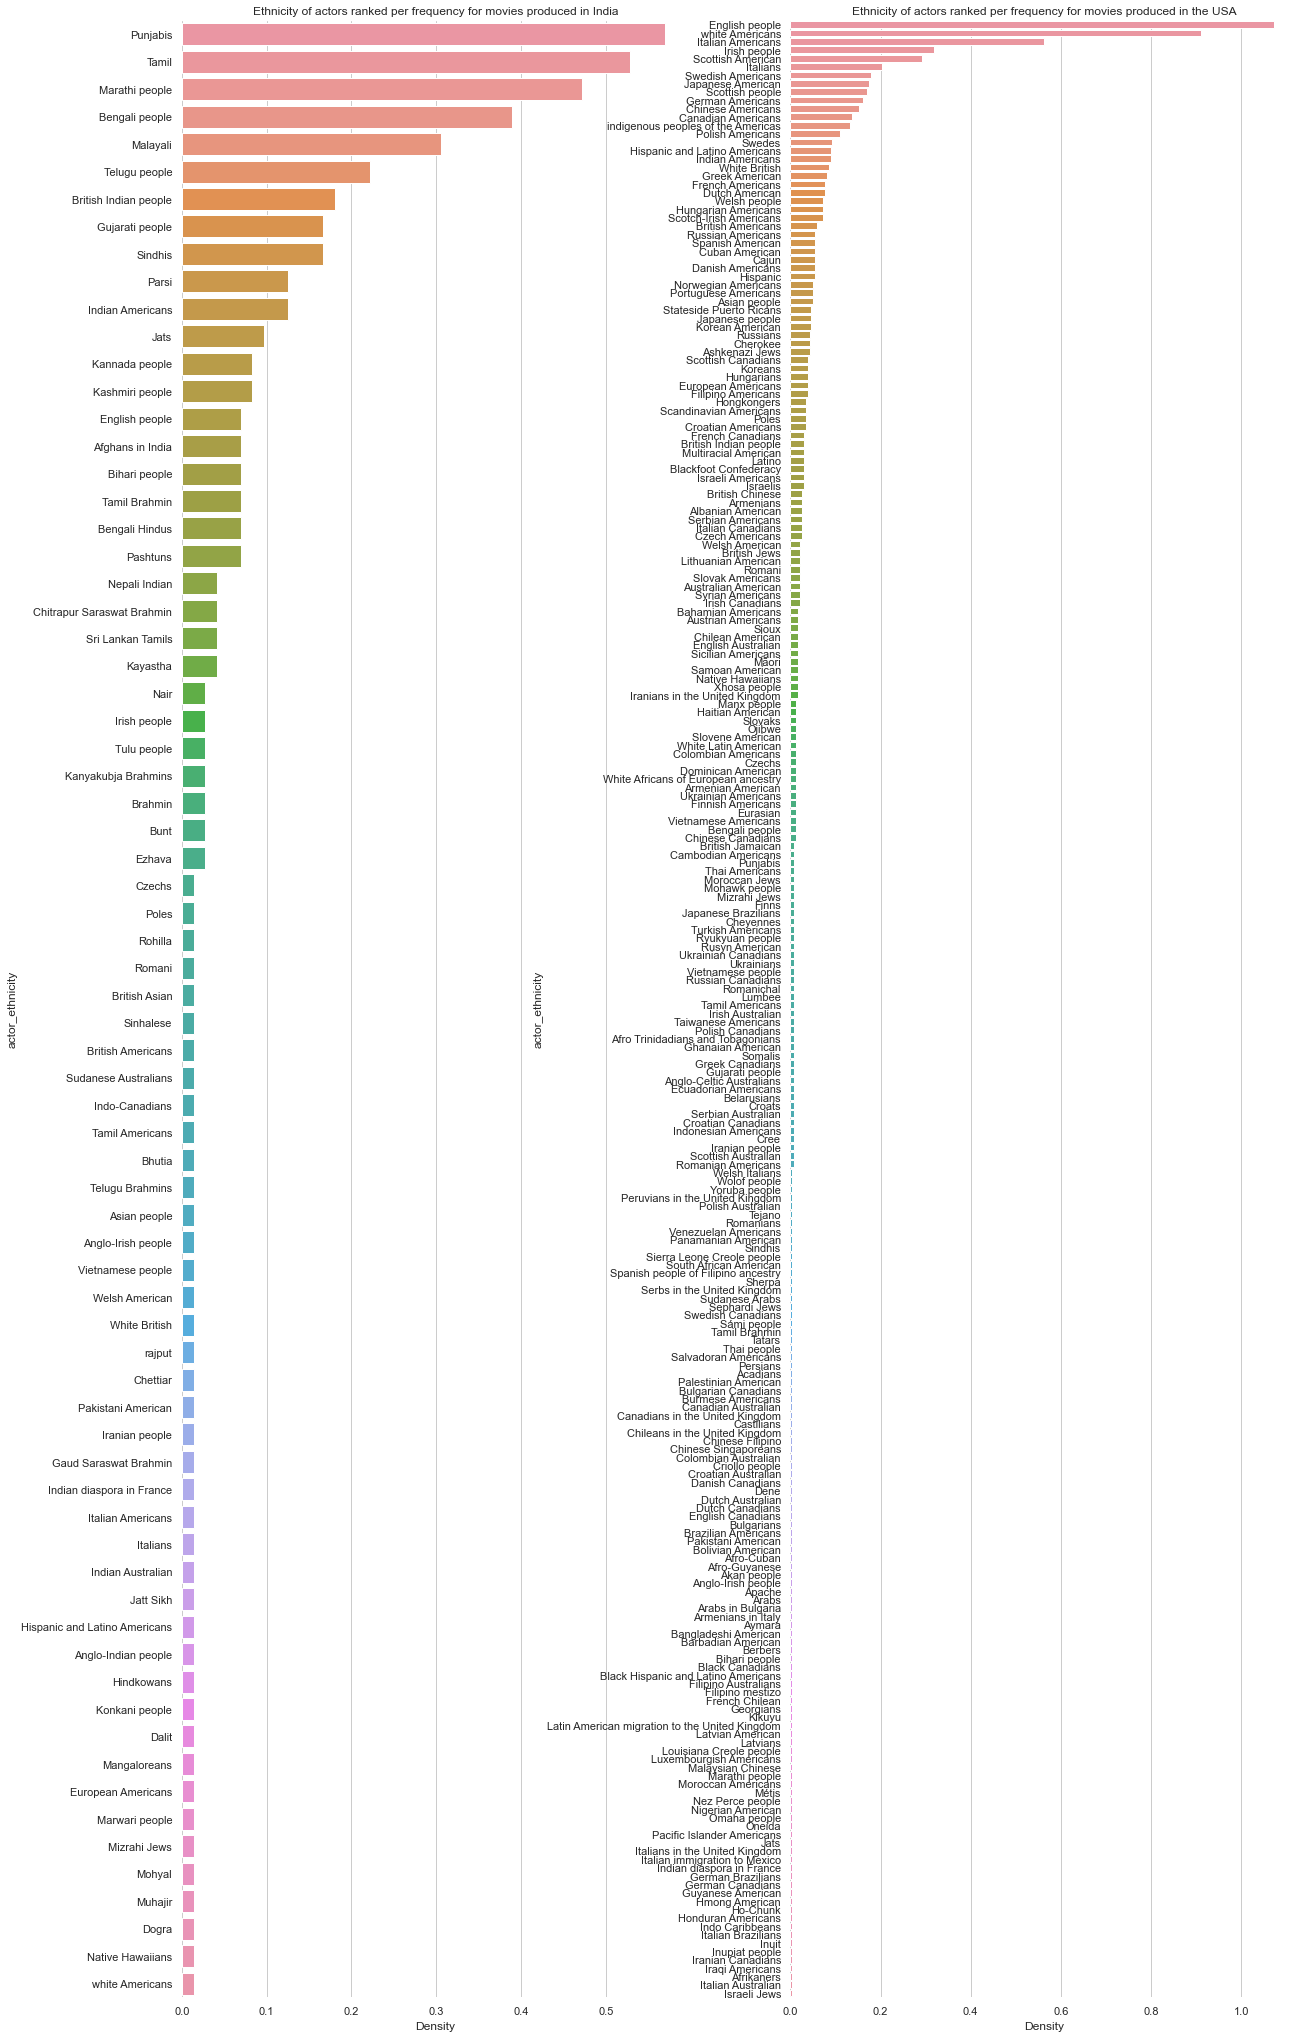

In [69]:
plt.figure(figsize=(20,80))
plt.subplot(2,2,1)
plt.title('Ethnicity of actors ranked per frequency for movies produced in India')
sns.barplot(data = ethnicity_data_india, y = ethnicity_data_india.index,  x = 'count', orient='h', order=ethnicity_data_india.sort_values(by = 'count', ascending=False).index)
sns.despine(left=True, bottom=True)
plt.xlabel('Density')


plt.subplot(2,2,2)
plt.title('Ethnicity of actors ranked per frequency for movies produced in the USA')
sns.barplot(data = ethnicity_data_usa, y = ethnicity_data_usa.index,  x = 'count', orient='h', order=ethnicity_data_usa.sort_values(by = 'count', ascending=False).index)
sns.despine(left=True, bottom=True)
plt.xlabel('Density')

plt.show()

Unsurprisingly, most ethnicities represented in the american films are descendent of immigrants, and most ethnicities represented in indian films are indian or more generally south-Asian. Also unsurprisingly, There are a lot more different ethnicities represented in films produced in the US compared to films produced in India. This might be due to the US being a more cosmopolite country, and to the difference in amout of information we have in our dataset

We can try investigate further the differences in representations in the industies, looking at the ethnicities represented in both industries

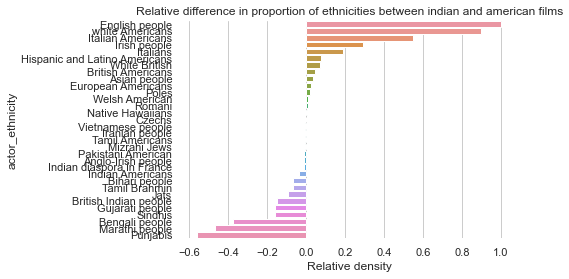

In [70]:
# negative values represent ethnicities more represented in the indian film industry, and vice versa
compared_ethnicities = (ethnicity_data_usa['count'] - ethnicity_data_india['count']).dropna()

plt.title('Relative difference in proportion of ethnicities between indian and american films')
sns.barplot(y = compared_ethnicities.index,  x = compared_ethnicities.values, orient='h', order=compared_ethnicities.sort_values(ascending=False).index)
sns.despine(left=True, bottom=True)
plt.xlabel('Relative density')
plt.show()

## Analysis of character data: conclusion

In [71]:
print('Number of indian film actors we have every features for:', unique_actors_merged[unique_actors_merged['country'] == 'India'].dropna().shape[0])
print('Number of american film actors we have every features for:', unique_actors_merged[unique_actors_merged['country'] == 'USA'].dropna().shape[0])

Number of indian film actors we have every features for: 350
Number of american film actors we have every features for: 1934


In [72]:
print('Number of indian film actors we have everything but ethnicity for:', unique_actors_merged[unique_actors_merged['country'] == 'India']['actor_gender'].shape[0])
print('Number of american film actors we have everything but ethnicity for:', unique_actors_merged[unique_actors_merged['country'] == 'USA']['actor_gender'].shape[0])

Number of indian film actors we have everything but ethnicity for: 5072
Number of american film actors we have everything but ethnicity for: 57830


If we consider only actors where we have all the available informations (gender, country the actors plays in, and ethnicity) we only get 354 indian film actors and 1967 american film actors. This is not enough to perform an analysis through time while taking into account actor ethnicity.

On the other hand, we have substantially more data on gender so taking it into account could be interesting for time-wise analysis for example.

## Name clusters data

In [73]:
names = ['character_name', 'actor_reference']
name_clusters_data = pd.read_csv(data_folder + 'name.clusters.txt', names = names, sep = '\t', )

name_clusters_data.head(10)

,character_name,actor_reference
0,Stuart Little,/m/0k3w9c
1,Stuart Little,/m/0k3wcx
2,Stuart Little,/m/0k3wbn
3,John Doe,/m/0jyg35
4,John Doe,/m/0k2_zn
5,Josh Framm,/m/0jt3p3
6,Josh Framm,/m/0jt3t3
7,Caspian X,/m/0646flc
8,Caspian X,/m/02vd12n
9,Apostle Peter,/m/02vd6_v


## **Tvtropes clusters data**

In [74]:
#Read tv tropes data
tv_trope = pd.read_csv(data_folder + 'tvtropes.clusters.txt', sep='\t', names= ['character_type', 'instances'])

tv_trope.head()

,character_type,instances
0,absent_minded_professor,"{""char"": ""Professor Philip Brainard"", ""movie"":..."
1,absent_minded_professor,"{""char"": ""Professor Keenbean"", ""movie"": ""Richi..."
2,absent_minded_professor,"{""char"": ""Dr. Reinhardt Lane"", ""movie"": ""The S..."
3,absent_minded_professor,"{""char"": ""Dr. Harold Medford"", ""movie"": ""Them!..."
4,absent_minded_professor,"{""char"": ""Daniel Jackson"", ""movie"": ""Stargate""..."


### Formatting data

In [75]:
#Remove {} strings
tv_trope['instances'] = tv_trope['instances'].str[1:-1]

split_tv = tv_trope.copy()

#Split on , and : to separate into different columns
split_tv = tv_trope['instances'].str.split('[,:]', expand=True)

#Name the columns accordingly
cleaned_tv = split_tv.rename(columns={split_tv.columns[1]: 'character_name', split_tv.columns[3]: 'movie_name', split_tv.columns[5]: 'char_act_id',split_tv.columns[7]: 'actor_name'})

#Drop the un-necessary columns
cleaned_tv = cleaned_tv.drop(columns=[0,2,4,6,8,9,10])

#Remove the ""
cleaned_tv = cleaned_tv.applymap(lambda s : re.sub(r'"', " ", s))

#Make everything lowercases 
cleaned_tv = cleaned_tv.applymap(lambda x: str.casefold(x))

characters = tv_trope.character_type

#Join to have the characters too 
final_tv = cleaned_tv.join(characters, how= 'left')

final_tv.head()

,character_name,movie_name,char_act_id,actor_name,character_type
0,professor philip brainard,flubber,/m/0jy9q0,robin williams,absent_minded_professor
1,professor keenbean,richie rich,/m/02vchl3,michael mcshane,absent_minded_professor
2,dr. reinhardt lane,the shadow,/m/0k6fkc,ian mckellen,absent_minded_professor
3,dr. harold medford,them!,/m/0k6_br,edmund gwenn,absent_minded_professor
4,daniel jackson,stargate,/m/0k3rhh,james spader,absent_minded_professor


In [76]:
#Check if there is any movies in the tv tropes present in our movie data set
list_ = final_tv['movie_name']

movies_data['movie_name'].where(movies_data['movie_name'].isin(list_))

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
81736    NaN
81737    NaN
81738    NaN
81739    NaN
81740    NaN
Name: movie_name, Length: 81741, dtype: object

In [77]:
#Check if there is any actors in the tv tropes present in our movie data set
list_1 = final_tv['actor_name']

movies_data['movie_name'].where(movies_data['movie_name'].isin(list_1)).dropna()

Series([], Name: movie_name, dtype: object)

# Creating features based on summaries data

In [ ]:
summaries = pd.read_csv(data_folder + 'plot_summaries.txt', sep = '\r', names = ['summaries'])
summaries = summaries['summaries'].str.split("\t", expand = True)
summaries = summaries.rename(columns= {0:'wikipedia_movie_id',1: 'summaries'})
summaries['summaries'] = summaries['summaries'].str.lower()
summaries['wikipedia_movie_id'] = summaries['wikipedia_movie_id'].astype(int)
summaries.head(10)

In [ ]:
indian_summaries = summaries[summaries['wikipedia_movie_id'].isin(indian_movies['wikipedia_movie_id'])]
indian_summaries = indian_summaries.reset_index(drop = True)
indian_summaries.head()

In [ ]:
american_summaries = summaries[summaries['wikipedia_movie_id'].isin(american_movies['wikipedia_movie_id'])]
american_summaries = american_summaries.reset_index(drop = True)
american_summaries.head()

## LDA Topic Detection Analysis

### Data pre-processing

Each NLP task requires some sort of data pre-processing to make data eligible for modeling. We will perform the following steps:

- Removing punctuation
- Tokenization: Splitting sentences into word-sized chunks, called tokens.
- Stopwords removal: Stopwords are English words that don’t add any value to the analysis. Removing them will help the model to find patterns more easily.
- Words with fewer than three letters are removed.
- Lemmatization: Converting words to their base using morphological analysis.
- Make bigrams: a bigram is a sequence of two adjacent elements from a string that combines to generate a more understandable form (e.g., [“data” , “science”] => [“data science”]

In [ ]:
# Run in python console
import nltk; nltk.download('stopwords')
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [ ]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [ ]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

In [ ]:
summaries_words = list(sent_to_words(summaries['summaries']))

print(summaries_words[:1])

In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(summaries_words, min_count=15, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(summaries_words, threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [ ]:
# Define functions for stopwords, bigrams, trigrams and lemmatization

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags and len(token)>3])
    return texts_out

In [ ]:
# Remove Stop Words
summaries_words_no_stopwords = remove_stopwords(summaries_words)

# Form Bigrams
summaries_words_bigrams = make_bigrams(summaries_words_no_stopwords)

# Do lemmatization keeping only noun, adj, vb, adv
summaries_words_lemmatized = lemmatization(summaries_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [ ]:
#This is just to avoid all the computation time and have the data frame already ready to work on
#summaries_words_lemmatized_csv = pd.DataFrame(summaries_words_lemmatized)
#summaries_words_lemmatized_csv.to_csv(data_folder + 'summaries_words_lemmatized_csv.csv')
#summaries_words_lemmatized = pd.read_csv(data_folder + 'summaries_words_lemmatized.csv')

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(summaries_words_lemmatized)

# Remove rare and common tokens.
# Filter out words that occur too frequently or too rarely.
max_freq = 0.5
min_wordcount = 15
id2word.filter_extremes(no_below=min_wordcount, no_above=max_freq)

# Create Corpus
texts = summaries_words_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

How to choose the number of topics ? 

In [ ]:
from gensim.models import CoherenceModel # spaCy for preprocessing

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    seed = 80699
    base_models = dict()
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics, random_state=seed)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
model_list, coherence_values = compute_coherence_values(dictionary = id2word, corpus = corpus, texts = texts, start=2, limit=20, step=3)

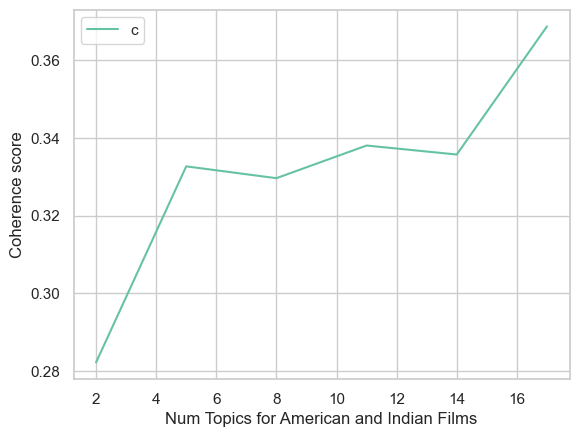

In [ ]:
limit=20; start=2; step=3
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics for American and Indian Films")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.2822
Num Topics = 5  has Coherence Value of 0.3327
Num Topics = 8  has Coherence Value of 0.3296
Num Topics = 11  has Coherence Value of 0.338
Num Topics = 14  has Coherence Value of 0.3357
Num Topics = 17  has Coherence Value of 0.3687


If the coherence score seems to keep increasing, it may make better sense to pick the model that gave the highest CV before flattening out.
So here, we choose 11 as the optimal numbers of topics.

In [ ]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.014*"find" + 0.013*"murder" + 0.008*"death" + 0.007*"woman" + '
  '0.007*"kill" + 0.007*"body" + 0.006*"police" + 0.006*"tell" + 0.006*"take" '
  '+ 0.006*"discover"'),
 (1,
  '0.014*"gang" + 0.009*"town" + 0.008*"fight" + 0.008*"take" + 0.008*"film" + '
  '0.007*"horse" + 0.006*"game" + 0.006*"shoot" + 0.006*"billy" + '
  '0.006*"kill"'),
 (2,
  '0.008*"ship" + 0.008*"destroy" + 0.007*"take" + 0.007*"world" + '
  '0.007*"king" + 0.007*"power" + 0.007*"use" + 0.006*"earth" + 0.006*"attack" '
  '+ 0.006*"battle"'),
 (3,
  '0.016*"band" + 0.007*"song" + 0.007*"show" + 0.007*"perform" + 0.006*"find" '
  '+ 0.006*"music" + 0.006*"make" + 0.005*"diamond" + 0.005*"leave" + '
  '0.005*"friend"'),
 (4,
  '0.010*"tell" + 0.010*"go" + 0.009*"find" + 0.009*"leave" + 0.009*"back" + '
  '0.008*"take" + 0.007*"see" + 0.007*"try" + 0.006*"room" + 0.006*"say"'),
 (5,
  '0.022*"school" + 0.013*"student" + 0.010*"friend" + 0.010*"college" + '
  '0.009*"take" + 0.009*"get" + 0.008*"johnny" + 0.

In [ ]:
import spacy# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
%matplotlib inline


data = pyLDAvis.gensim_models.prepare(topic_model = optimal_model, corpus = corpus, dictionary = id2word)
pyLDAvis.display(data)

/Users/lindadelacombaz/opt/anaconda3/envs/ada/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/Users/lindadelacombaz/opt/anaconda3/envs/ada/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/lindadelacombaz/opt/anaconda3/envs/ada/lib/python3.9/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Users/lindadelacombaz/opt/anaconda3/envs/ada/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/lin

In [ ]:
def format_topics_sentences(ldamodel=optimal_model, corpus=corpus):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['document_no', 'dominant_topic', 'topic_perc_contrib', 'keywords']

#add original text
df_dominant_topic = df_dominant_topic.merge(summaries, how = 'left', right_index=True, left_on='document_no')

# Show
df_dominant_topic.head(10)

In [ ]:
# Group top 5 sentences under each topic
sent_topics_sorteddf = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
#sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords"]

sent_topics_sorteddf = sent_topics_sorteddf.join(summaries)

# Show
sent_topics_sorteddf

### Get dummy variables to create the features

In [ ]:
topic_features_indian = df_dominant_topic.copy()

topic_features_indian = df_dominant_topic[df_dominant_topic['wikipedia_movie_id'].isin(indian_movies['wikipedia_movie_id'])]

topic_features_indian = topic_features_indian[['dominant_topic','wikipedia_movie_id']]

topic_features_indian_dum = pd.get_dummies(topic_features_indian['dominant_topic'])

topic_features_indian_final = topic_features_indian_dum.join(topic_features_indian['wikipedia_movie_id'])

topic_features_indian_final.head()

In [ ]:
topic_features_american = df_dominant_topic.copy()

topic_features_american = df_dominant_topic[df_dominant_topic['wikipedia_movie_id'].isin(american_movies['wikipedia_movie_id'])]

topic_features_american = topic_features_american[['dominant_topic','wikipedia_movie_id']]

topic_features_american_dum = pd.get_dummies(topic_features_american['dominant_topic'])

topic_features_american_final = topic_features_american_dum.join(topic_features_american['wikipedia_movie_id'])

topic_features_american_final.head()

# Sentiment Analysis

In [85]:
print('The mean length of american summaries is {1:.2f} words and for indian summaries it is {0:.2f} words.'.format(
    np.mean([len(ele.split(' ')) for ele in indian_summaries['summaries']]),
    np.mean([len(ele.split(' ')) for ele in american_summaries['summaries']])
))

The mean length of american summaries is 346.30 words and for indian summaries it is 301.85 words.


In [86]:
#can take up to 3min to run

#defining analyzer
analyzer = SentimentIntensityAnalyzer()

#computing sentiments for each summary
indian_sentiments = pd.DataFrame([analyzer.polarity_scores(summary) for summary in indian_summaries['summaries']])
american_sentiments = pd.DataFrame([analyzer.polarity_scores(summary) for summary in american_summaries['summaries']])

#adding wikipedia id for future merges
indian_sentiments['wikipedia_movie_id']=indian_summaries['wikipedia_movie_id']
american_sentiments['wikipedia_movie_id']=american_summaries['wikipedia_movie_id']
indian_sentiments.head()

,neg,neu,pos,compound,wikipedia_movie_id
0,0.178,0.704,0.119,-0.9867,20663735
1,0.082,0.757,0.162,0.9920,8388648
2,0.078,0.867,0.054,-0.7315,2254491
3,0.068,0.795,0.137,0.9493,4356664
4,0.065,0.835,0.100,0.8778,19174305


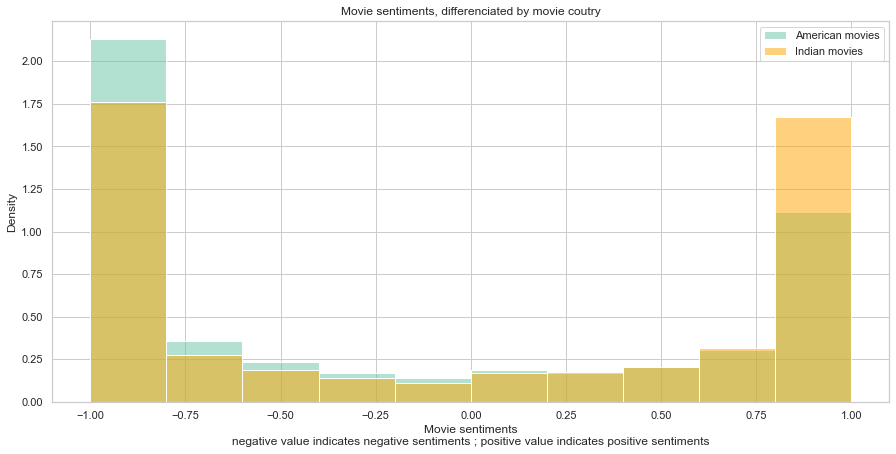

In [87]:
plt.figure(figsize=(15,7))

sns.histplot(american_sentiments['compound'], alpha =.5, stat = 'density', bins = 10)
sns.histplot(indian_sentiments['compound'], alpha=.5, color = 'orange', stat = 'density', bins = 10)
plt.legend(labels=["American movies","Indian movies"])
plt.xlabel('Movie sentiments\nnegative value indicates negative sentiments ; positive value indicates positive sentiments')
plt.title('Movie sentiments, differenciated by movie coutry')
plt.show()

# Creating features based on actor data

### Creating the output datasets

In [88]:
df_features_indian_actors = pd.DataFrame({'wikipedia_movie_id':[]})
df_features_american_actors = pd.DataFrame({'wikipedia_movie_id':[]})

In [89]:
# get the ids of the movies from the summaries
df_features_indian_actors['wikipedia_movie_id']=cut_indian_movies['wikipedia_movie_id']
df_features_american_actors['wikipedia_movie_id']=cut_american_movies['wikipedia_movie_id']

### Getting the mean actor age per gender for each movie

In [90]:
# getting the mean age per gender for indian and american films
mean_male_actor_age_india = indian_film_male.groupby('wikipedia_movie_id', as_index=False)['actor_age_at_movie_release'].agg({'mean_male_actor_age': np.mean})
mean_female_actor_age_india = indian_film_female.groupby('wikipedia_movie_id', as_index=False)['actor_age_at_movie_release'].agg({'mean_female_actor_age': np.mean})

mean_male_actor_age_america = american_film_male.groupby('wikipedia_movie_id', as_index=False)['actor_age_at_movie_release'].agg({'mean_male_actor_age': np.mean})
mean_female_actor_age_america = american_film_female.groupby('wikipedia_movie_id', as_index=False)['actor_age_at_movie_release'].agg({'mean_female_actor_age': np.mean})


df_features_indian_actors = pd.merge(df_features_indian_actors, mean_male_actor_age_india, on = 'wikipedia_movie_id', how = 'left') 
df_features_indian_actors = pd.merge(df_features_indian_actors, mean_female_actor_age_india, on = 'wikipedia_movie_id', how = 'left')

df_features_american_actors = pd.merge(df_features_american_actors, mean_male_actor_age_america, on = 'wikipedia_movie_id', how = 'left')
df_features_american_actors = pd.merge(df_features_american_actors, mean_female_actor_age_america, on = 'wikipedia_movie_id', how = 'left')


### Getting the mean number of films actors in each movie played in

In [91]:
# merging the number of films an actor played in with the rest of the film data
all_american_actors_ext = all_american_actors.merge(all_american_actors.actor_name.value_counts().reset_index(), left_on = 'actor_name', right_on = 'index', how = 'left')
all_american_actors_ext = all_american_actors_ext.groupby('wikipedia_movie_id', as_index=False)['actor_name_y'].agg({'average_number_of_films_actors_played_in': np.mean})

all_indian_actors_ext = all_indian_actors.merge(all_indian_actors.actor_name.value_counts().reset_index(), left_on = 'actor_name', right_on = 'index', how = 'left')
all_indian_actors_ext = all_indian_actors_ext.groupby('wikipedia_movie_id', as_index=False)['actor_name_y'].agg({'average_number_of_films_actors_played_in': np.mean})

# merging with features
df_features_american_actors = pd.merge(df_features_american_actors, all_american_actors_ext[['wikipedia_movie_id', 'average_number_of_films_actors_played_in']], on = 'wikipedia_movie_id', how = 'left')
df_features_indian_actors = pd.merge(df_features_indian_actors, all_indian_actors_ext[['wikipedia_movie_id', 'average_number_of_films_actors_played_in']], on = 'wikipedia_movie_id', how = 'left')

### Getting the percent of actress in each movie

In [92]:
def percent_female(x):
    try:
        return x.value_counts().to_dict()['F']/len(x)
    except:
        return 0

percent_female_american_films = all_american_actors.groupby('wikipedia_movie_id', as_index=False)['actor_gender'].apply(percent_female)
percent_female_american_films.rename(columns = {'actor_gender':'percent_female_cast'}, inplace = True)
percent_female_indian_films = all_indian_actors.groupby('wikipedia_movie_id', as_index=False)['actor_gender'].apply(percent_female)
percent_female_indian_films.rename(columns = {'actor_gender':'percent_female_cast'}, inplace = True)

# merging with features
df_features_american_actors = pd.merge(df_features_american_actors, percent_female_american_films, on = 'wikipedia_movie_id', how = 'left')
df_features_indian_actors = pd.merge(df_features_indian_actors, percent_female_indian_films, on = 'wikipedia_movie_id', how = 'left')

# drop the rows with no wikipedia_movie_id
df_features_american_actors.dropna(subset = ['wikipedia_movie_id'], inplace = True)
df_features_indian_actors.dropna(subset = ['wikipedia_movie_id'], inplace = True)

In [93]:
# merging with the sentiment data
df_features_american_actors = pd.merge(df_features_american_actors, american_sentiments[['wikipedia_movie_id', 'compound']], on = 'wikipedia_movie_id', how = 'left')
df_features_indian_actors = pd.merge(df_features_indian_actors, indian_sentiments[['wikipedia_movie_id', 'compound']], on = 'wikipedia_movie_id', how = 'left')

# Predicting the average rating

## Pre-processing the features

In [94]:
test_indian = indian_movies.copy()
#remove {}
test_indian['cleared_movie_genres'] = test_indian['movie_genres'].str[1:-1]

#remove films without genre
test_indian = test_indian.query("cleared_movie_genres != ''")
#test_indian['cleared_movie_genres'] = [ele.split(':')[1] for ele in test_indian['cleared_movie_genres']]

test_american = american_movies.copy()
#remove {}
test_american['cleared_movie_genres'] = test_american['movie_genres'].str[1:-1]
#remove films without genre
test_american = test_american.query("cleared_movie_genres != ''")


In [126]:
test_american.head()

,index,wikipedia_movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,averageRating,numVotes,isAdult,centeredRating,cleared_movie_genres
0,0,975900,/m/03vyhn,ghosts of mars,2001.0,14010832.0,98.0,"{""/m/02h40lc"": ""english language""}","{""/m/09c7w0"": ""united states of america""}","{""/m/01jfsb"": ""thriller"", ""/m/06n90"": ""science...",NaN,NaN,NaN,NaN,01jfsb thriller 06n90 science fiction 03npn ho...
1,1,3196793,/m/08yl5d,getting away with murder: the jonbenét ramsey ...,2000.0,NaN,95.0,"{""/m/02h40lc"": ""english language""}","{""/m/09c7w0"": ""united states of america""}","{""/m/02n4kr"": ""mystery"", ""/m/03bxz7"": ""biograp...",NaN,NaN,NaN,NaN,02n4kr mystery 03bxz7 biographical 07s9rl0 dra...
2,5,13696889,/m/03cfc81,the gangsters,1913.0,NaN,35.0,"{""/m/06ppq"": ""silent film"", ""/m/02h40lc"": ""eng...","{""/m/09c7w0"": ""united states of america""}","{""/m/02hmvc"": ""short film"", ""/m/06ppq"": ""silen...",NaN,NaN,NaN,NaN,02hmvc short 06ppq silent 0219x_ indie 01g6gs ...
3,7,10408933,/m/02qc0j7,alexander's ragtime band,1938.0,3600000.0,106.0,"{""/m/02h40lc"": ""english language""}","{""/m/09c7w0"": ""united states of america""}","{""/m/04t36"": ""musical"", ""/m/01z4y"": ""comedy"", ...",NaN,NaN,NaN,NaN,04t36 musical 01z4y comedy 01g6gs black-and-white
4,10,175026,/m/017n1p,sarah and son,1930.0,NaN,86.0,"{""/m/02h40lc"": ""english language""}","{""/m/09c7w0"": ""united states of america""}","{""/m/07s9rl0"": ""drama"", ""/m/01g6gs"": ""black-an...",5.4,271.0,0,-0.715215,07s9rl0 drama 01g6gs black-and-white


In [95]:
movie_genre_imdb =  pd.Series(['action','adventure','animation','biography','comedy','crime','documentary','drama','family',
                              'fantasy','noir','history', 'horror','musical','mystery','romance','sci-fi','short Film',
                              'sport','superhero','thriller','war','western'])
spec_chars = [':', '"', ',', '/m/', 'film']

In [96]:

for char in spec_chars:
    test_indian['cleared_movie_genres'] = test_indian['cleared_movie_genres'].str.replace(char, '')
    test_indian['cleared_movie_genres'] = test_indian['cleared_movie_genres'].str.replace('  ', ' ')
    test_american['cleared_movie_genres'] = test_american['cleared_movie_genres'].str.replace(char, '')
    test_american['cleared_movie_genres'] = test_american['cleared_movie_genres'].str.replace('  ', ' ')

In [97]:
genre_dummies_indian = pd.DataFrame()
for char in movie_genre_imdb:
    genre_dummies_indian[char] = pd.Series(test_indian['cleared_movie_genres'].apply(lambda x: pd.Series(x).str.contains(char[:3]).any().astype('int')))
    
genre_dummies_american = pd.DataFrame()
for char in movie_genre_imdb:
    genre_dummies_american[char] = pd.Series(test_american['cleared_movie_genres'].apply(lambda x: pd.Series(x).str.contains(char[:3]).any().astype('int')))

In [291]:
genre_dummies_indian['wikipedia_movie_id'] = test_indian['wikipedia_movie_id']
genre_dummies_american['wikipedia_movie_id'] = test_american['wikipedia_movie_id']
features_indian = pd.merge(genre_dummies_indian, df_features_indian_actors, on= 'wikipedia_movie_id', how = 'right')
features_american = pd.merge(genre_dummies_american, df_features_american_actors, on= 'wikipedia_movie_id', how = 'right')

In [292]:
rating_indian = cut_indian_movies.dropna(subset = 'averageRating')[['wikipedia_movie_id', 'averageRating']]
rating_american = cut_american_movies.dropna(subset = 'averageRating')[['wikipedia_movie_id', 'averageRating']]

In [293]:
features_indian = pd.merge(features_indian, rating_indian, on= 'wikipedia_movie_id', how = 'right')
features_american = pd.merge(features_american, rating_american, on= 'wikipedia_movie_id', how = 'right')
features_indian = pd.merge(features_indian, test_indian[['wikipedia_movie_id', 'movie_release_date']], on= 'wikipedia_movie_id', how = 'left')
features_american = pd.merge(features_american, test_american[['wikipedia_movie_id', 'movie_release_date']], on= 'wikipedia_movie_id', how = 'left')

In [294]:
features_indian_train = pd.concat([features_indian.iloc[:,0:23].fillna(0), features_indian.iloc[:,24:29].fillna(features_indian.iloc[:,24:29].mean())], axis = 1)
features_american_train = pd.concat([features_american.iloc[:,0:23].fillna(0), features_american.iloc[:,24:29].fillna(features_american.iloc[:,24:29].mean())], axis = 1)

american_ratings = features_american[['averageRating', 'movie_release_date']]
indian_ratings = features_indian[['averageRating', 'movie_release_date']]

#standardize the data
features_indian_train.iloc[:,23:] = (features_indian_train.iloc[:,23:] - features_indian_train.iloc[:,23:].mean())/features_indian_train.iloc[:,23:].std()
features_american_train.iloc[:,23:] = (features_american_train.iloc[:,23:] - features_american_train.iloc[:,23:].mean())/features_american_train.iloc[:,23:].std()

## Linear regression (for p-values)

In [295]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [296]:
features_indian_train.rename(columns={'short Film': 'short', 'sci-fi':'scifi'}, inplace=True)
features_american_train.rename(columns={'short Film': 'short', 'sci-fi':'scifi'}, inplace=True)

In [297]:
form = 'averageRating ~ ' + ' + '.join('C(' + features_indian_train.columns[:23] + ')') + ' + ' + ' + '.join(features_indian_train.columns[23:])
form2 = 'averageRating ~ ' + ' + '.join('C(' + features_american_train.columns[:23] + ')') + ' + ' + ' + '.join(features_american_train.columns[23:])

In [298]:
mod = smf.ols(formula=form, data=pd.concat([indian_ratings['averageRating'], features_indian_train], axis = 1)).fit()
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          averageRating   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.095
Method:                 Least Squares   F-statistic:                     8.337
Date:                Wed, 14 Dec 2022   Prob (F-statistic):           5.32e-31
Time:                        14:24:05   Log-Likelihood:                -3106.4
No. Observations:                1897   AIC:                             6269.
Df Residuals:                    1869   BIC:                             6424.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                    6.5505      0.059    111.702      0.000       6.435       6.666
C(action)[T.1.0]                            -0.3709      0.082     -4.512      0.000      -0.532      -0.210
C(adventure)[T.1.0]                         -0.1573      0.144     -1.094      0.274      -0.439       0.125
C(animation)[T.1.0]                          2.3201      1.395      1.663      0.097      -0.416       5.056
C(biography)[T.1.0]                          0.6364      0.529      1.203      0.229      -0.401       1.673
C(comedy)[T.1.0]                            -0.0916      0.078     -1.179      0.239      -0.244       0.061
C(crime)[T.1.0]                             -0.1919      0.117     -1.638      0.102      -0.422       0.038
C(documentary)[T.1.0]                        0.9384      0.501      1.872      0.061      -0.045       1.921
C(drama)[T.1.0]                              0.0735      0.062      1.180      0.238      -0.049       0.196
C(family)[T.1.0]                             0.1938      0.106      1.827      0.068      -0.014       0.402
C(fantasy)[T.1.0]                            0.3097      0.239      1.294      0.196      -0.160       0.779
C(history)[T.1.0]                            1.2157      0.316      3.846      0.000       0.596       1.836
C(horror)[T.1.0]                            -0.6825      0.255     -2.681      0.007      -1.182      -0.183
C(musical)[T.1.0]                           -0.0456      0.080     -0.569      0.569      -0.203       0.112
C(mystery)[T.1.0]                            0.4740      0.239      1.987      0.047       0.006       0.942
C(romance)[T.1.0]                           -0.4022      0.071     -5.698      0.000      -0.541      -0.264
C(scifi)[T.1.0]                              0.7410      0.437      1.694      0.090      -0.117       1.599
C(short)[T.1.0]                              0.4119      0.661      0.623      0.533      -0.885       1.709
C(sport)[T.1.0]                              1.6838      0.729      2.311      0.021       0.255       3.113
C(superhero)[T.1.0]                         -0.7949      0.918     -0.866      0.387      -2.595       1.006
C(thriller)[T.1.0]                          -0.2019      0.111     -1.816      0.069      -0.420       0.016
C(war)[T.1.0]                                0.2692      0.407      0.662      0.508      -0.529       1.067
C(western)[T.1.0]                            0.3141      1.264      0.248      0.804      -2.166       2.794
mean_male_actor_age                         -0.1379      0.030     -4.548      0.000      -0.197      -0.078
mean_female_actor_age                       -0.0033      0.030     -0.109      0.913      -0.062       0.055
average_number_of_films_actors_

In [299]:
mod2 = smf.ols(formula=form2, data=pd.concat([american_ratings['averageRating'], features_american_train], axis = 1)).fit()
mod2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          averageRating   R-squared:                       0.309
Model:                            OLS   Adj. R-squared:                  0.306
Method:                 Least Squares   F-statistic:                     91.96
Date:                Wed, 14 Dec 2022   Prob (F-statistic):               0.00
Time:                        14:24:06   Log-Likelihood:                -8278.3
No. Observations:                5775   AIC:                         1.661e+04
Df Residuals:                    5746   BIC:                         1.681e+04
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                    5.9132      0.035    170.637      0.000       5.845       5.981
C(action)[T.1.0]                            -0.3618      0.053     -6.876      0.000      -0.465      -0.259
C(adventure)[T.1.0]                         -0.1113      0.049     -2.250      0.024      -0.208      -0.014
C(animation)[T.1.0]                          0.2083      0.068      3.051      0.002       0.074       0.342
C(biography)[T.1.0]                          0.2538      0.057      4.437      0.000       0.142       0.366
C(comedy)[T.1.0]                            -0.0640      0.032     -1.988      0.047      -0.127      -0.001
C(crime)[T.1.0]                             -0.0492      0.047     -1.049      0.294      -0.141       0.043
C(documentary)[T.1.0]                        0.8470      0.048     17.629      0.000       0.753       0.941
C(drama)[T.1.0]                              0.2567      0.033      7.859      0.000       0.193       0.321
C(family)[T.1.0]                             0.1051      0.051      2.066      0.039       0.005       0.205
C(fantasy)[T.1.0]                            0.0071      0.073      0.097      0.923      -0.135       0.149
C(noir)[T.1.0]                               0.6230      0.125      4.999      0.000       0.379       0.867
C(history)[T.1.0]                            0.2664      0.079      3.360      0.001       0.111       0.422
C(horror)[T.1.0]                            -1.2841      0.060    -21.415      0.000      -1.402      -1.167
C(musical)[T.1.0]                            0.3130      0.060      5.206      0.000       0.195       0.431
C(mystery)[T.1.0]                            0.2063      0.076      2.697      0.007       0.056       0.356
C(romance)[T.1.0]                            0.0093      0.044      0.211      0.833      -0.077       0.096
C(scifi)[T.1.0]                             -0.3622      0.065     -5.567      0.000      -0.490      -0.235
C(short)[T.1.0]                              1.7652      0.071     24.815      0.000       1.626       1.905
C(sport)[T.1.0]                             -0.1851      0.089     -2.080      0.038      -0.360      -0.011
C(superhero)[T.1.0]                          0.1251      0.119      1.050      0.294      -0.109       0.359
C(thriller)[T.1.0]                          -0.2784      0.049     -5.660      0.000      -0.375      -0.182
C(war)[T.1.0]                                0.1489      0.075      1.977      0.048       0.001       0.296
C(western)[T.1.0]                            0.4488      0.062      7.263      0.000       0.328       0.570
mean_male_actor_age                          0.0073      0.014      0.510      0.610      -0.021       0.035
mean_female_actor_age          

## Support-Vector Machine

In [300]:
# standardize the data
features_indian_train = (features_indian_train - features_indian_train.mean())/features_indian_train.std()
features_american_train = (features_american_train - features_american_train.mean())/features_american_train.std()

In [301]:
from sklearn.svm import SVR
from sklearn import model_selection, metrics
svr = SVR(kernel='linear', C=1.0)

In [302]:
svr.fit(features_indian_train.drop(columns='noir'), indian_ratings['averageRating'])
print('Mean negative squared error : {:.3f}'.format(np.mean(model_selection.cross_val_score(svr, features_indian_train.drop(columns='noir'), indian_ratings['averageRating'], scoring = 'neg_mean_squared_error', cv=5))))

Mean negative squared error : -1.644


We drop the feature 'noir' because it always 0 for Indian movies and thus lead to NaN when standardizing.

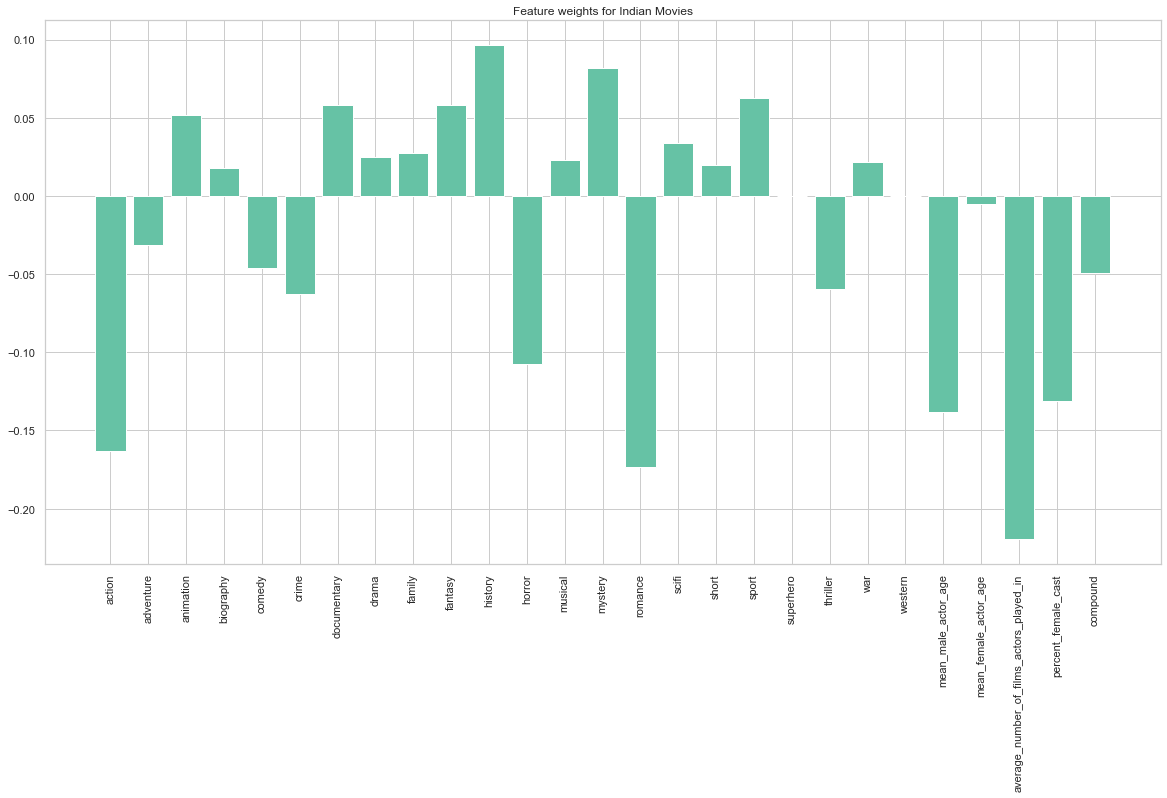

In [303]:
plt.figure(figsize=(20,10))
plt.bar(features_indian_train.drop(columns='noir').columns, svr.coef_[0])
plt.xticks(rotation=90)
plt.title('Feature weights for Indian Movies')
plt.show()

In [304]:
svr.fit(features_american_train, american_ratings['averageRating'])
print('Mean negative squared error : {:.3f}'.format(np.mean(model_selection.cross_val_score(svr, features_american_train, american_ratings['averageRating'], scoring = 'neg_mean_squared_error', cv=5))))

Mean negative squared error : -1.049


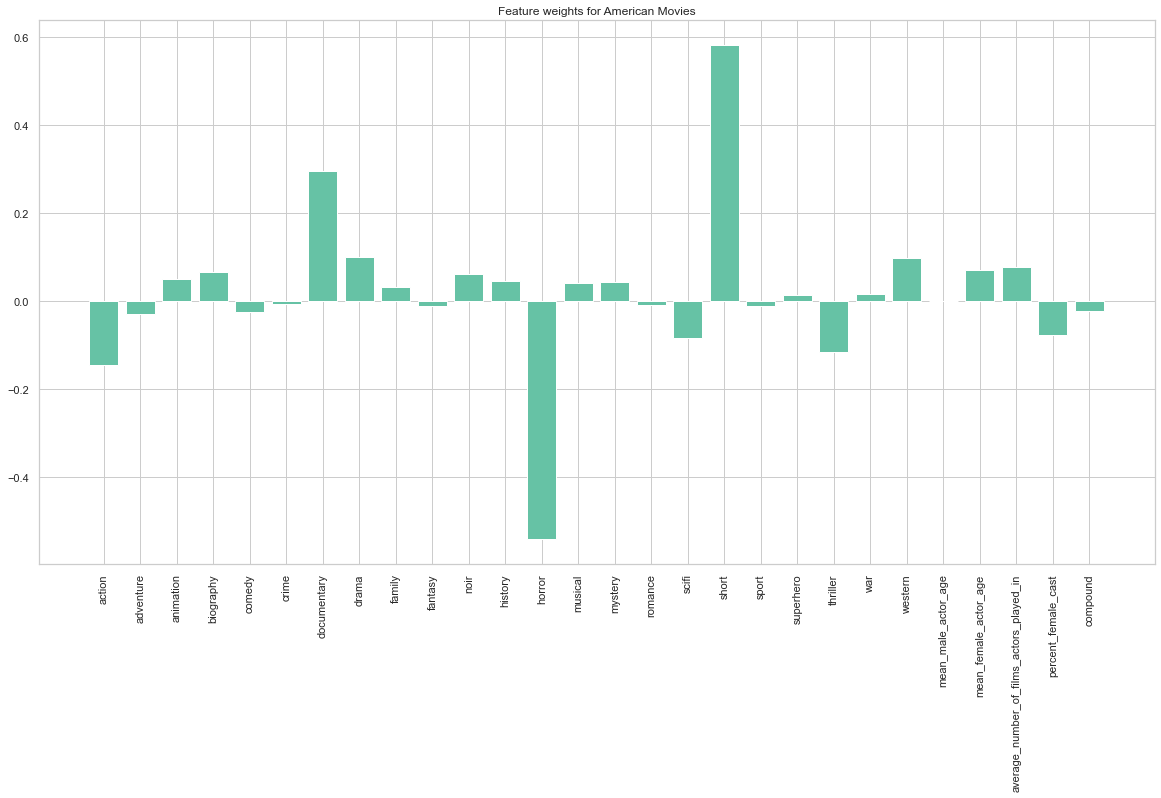

In [305]:
plt.figure(figsize=(20,10))
plt.bar(features_american_train.columns, svr.coef_[0])
plt.xticks(rotation=90)
plt.title('Feature weights for American Movies')
plt.show()

# Visualizing American and Indian movies in lower dimension spaces

In [306]:
labels = np.append(np.repeat('India', len(features_indian_train)), np.repeat('USA', len(features_american_train)))
features = pd.concat([features_indian_train, features_american_train], axis = 0)
# standardize the data
features = (features - features.mean())/features.std()
features.drop(columns='noir', inplace=True)

## PCA

In [307]:
from sklearn.svm import SVC
from sklearn import model_selection, metrics

svc = SVC(kernel='linear', C=1.0)
svc.fit(features, labels)
print('We can predict with an accuracy of {:.1%} if a movie is Indian or American'.format(np.mean(model_selection.cross_val_score(svc, features, labels, scoring = 'accuracy', cv=5))))

We can predict with an accuracy of 75.3% if a movie is Indian or American


This accuracy shows that there is a structure in the data that can be used to predict the country of the movie. We should see this structure in the PCA plot but we don't. Maybe by selecting the most important features we can reveal it?

In [308]:
feature_imp = pd.DataFrame(svc.coef_[0], index = features.columns, columns=['importance'])
feature_imp.sort_values(by='importance', ascending=False, inplace=True)
feature_imp.index

Index(['superhero', 'mean_male_actor_age', 'short', 'drama', 'scifi', 'action',
       'horror', 'thriller', 'percent_female_cast', 'musical', 'compound',
       'comedy', 'animation', 'romance', 'mean_female_actor_age', 'family',
       'war', 'mystery', 'crime', 'adventure', 'history', 'fantasy', 'sport',
       'average_number_of_films_actors_played_in', 'western', 'documentary',
       'biography'],
      dtype='object')

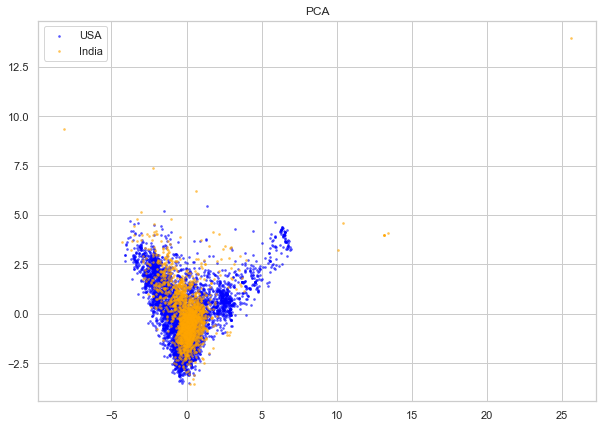

In [309]:
from sklearn.decomposition import PCA

pca = PCA(n_components=8)
features_red = pca.fit_transform(features)

plt.figure(figsize=(10,7))
plt.scatter(features_red[len(features_indian):,0], features_red[len(features_indian):,1], c = 'blue', s=3, alpha = 0.5, label = 'USA')
plt.scatter(features_red[:len(features_indian),0], features_red[:len(features_indian),1], c = 'orange', s=3, alpha = 0.5, label = 'India')
plt.legend()
plt.title('PCA')
plt.show()

## LDA

In [310]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=1)
features_red_lda = lda.fit_transform(features, labels)

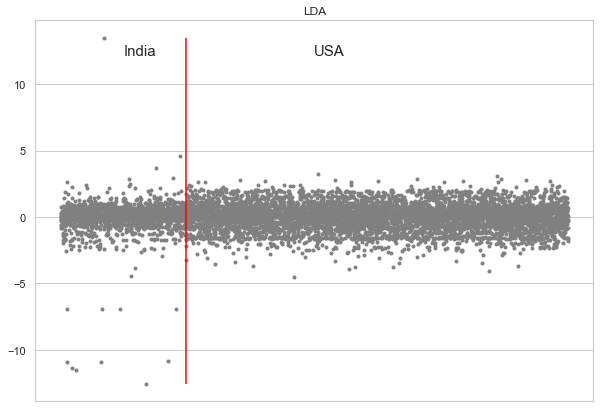

In [311]:
plt.figure(figsize=(10,7))
plt.plot(range(len(features_red_lda)), features_red_lda[:,0], 'o', markersize=3, c='grey')
plt.vlines(x = len(features_indian_train), ymin = min(features_red_lda[:,0]), ymax = max(features_red_lda[:,0]), color = 'red')
plt.text(len(features_indian_train)/2, max(features_red_lda[:,0])*0.9, 'India', fontsize=15)
plt.text(len(features_indian_train) + (len(features_american_train) - len(features_indian_train))/2, max(features_red_lda[:,0])*0.9, 'USA', fontsize=15)
plt.xticks([])
plt.title('LDA')
plt.show()

## Time series

In [312]:
features_indian_year = features_indian.drop(columns=['wikipedia_movie_id', 'averageRating', 'noir']).groupby('movie_release_date').mean()
features_american_year = features_american.drop(columns=['wikipedia_movie_id', 'averageRating', 'noir']).groupby('movie_release_date').mean()
features_indian_year.rename(columns={'short Film': 'short', 'sci-fi':'scifi'}, inplace=True)
features_american_year.rename(columns={'short Film': 'short', 'sci-fi':'scifi'}, inplace=True)

#standardize the data
features_indian_year = (features_indian_year - features_indian_year.mean())/features_indian_year.std()
features_american_year = (features_american_year - features_american_year.mean())/features_american_year.std()

### Time series analysis with Euclidean distance

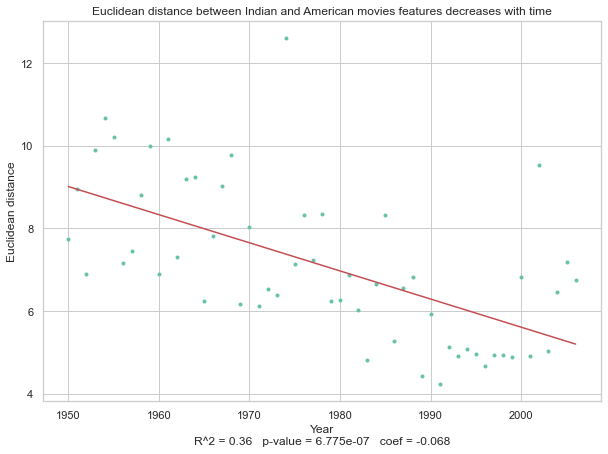

In [313]:
euclidean_dist = np.linalg.norm(features_american_year.loc[features_indian_year.index,:] - features_indian_year, axis=1)
dist_mod = smf.ols('euclidean_dist ~ features_indian_year.index', data=locals()).fit()
plt.figure(figsize=(10,7))
plt.plot(features_indian_year.index, euclidean_dist, 'o', markersize=3)
plt.plot(features_indian_year.index, dist_mod.predict(), 'r')
plt.xlabel('Year\nR^2 = {:.2f}   p-value = {:.3e}   coef = {:.3f}'.format(dist_mod.rsquared ,dist_mod.f_pvalue, dist_mod.params[1]))
plt.ylabel('Euclidean distance')
plt.title('Euclidean distance between Indian and American movies features decreases with time')
plt.show()

### Time series analysis with PCA

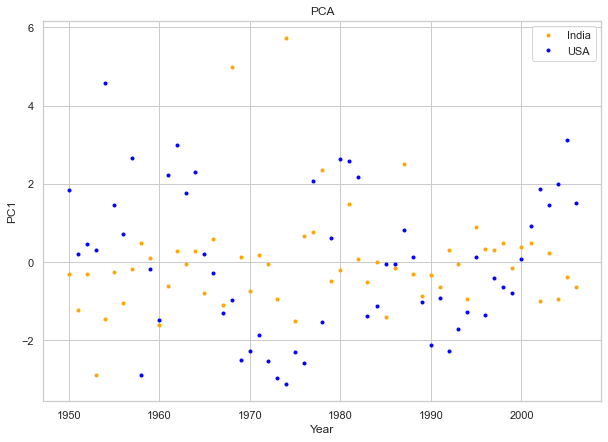

In [314]:
plt.figure(figsize=(10,7))
features_indian_year_red = pca.transform(features_indian_year)
features_american_year_red = pca.transform(features_american_year)
plt.plot(features_indian_year.index, features_indian_year_red[:,0], 'o', markersize=3, c='orange', label = 'India')
plt.plot(features_american_year.index, features_american_year_red[:,0], 'o', markersize=3, c='blue', label = 'USA')
plt.legend()
plt.title('PCA')
plt.xlabel('Year')
plt.ylabel('PC1')
plt.show()

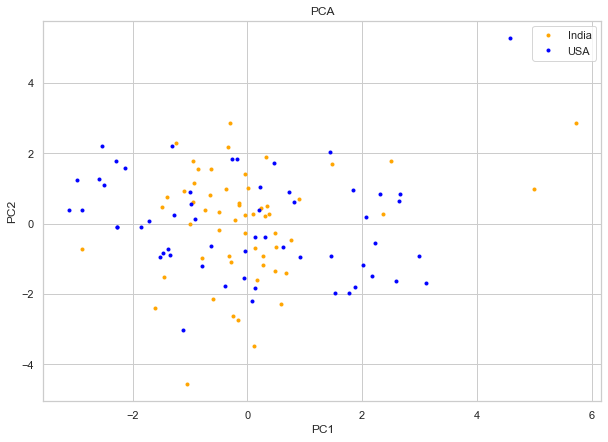

In [315]:
plt.figure(figsize=(10,7))
plt.plot(features_indian_year_red[:,0], features_indian_year_red[:,1], 'o', markersize=3, c='orange', label = 'India')
plt.plot(features_american_year_red[:,0], features_american_year_red[:,1], 'o', markersize=3, c='blue', label = 'USA')
plt.legend()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA')
plt.show()

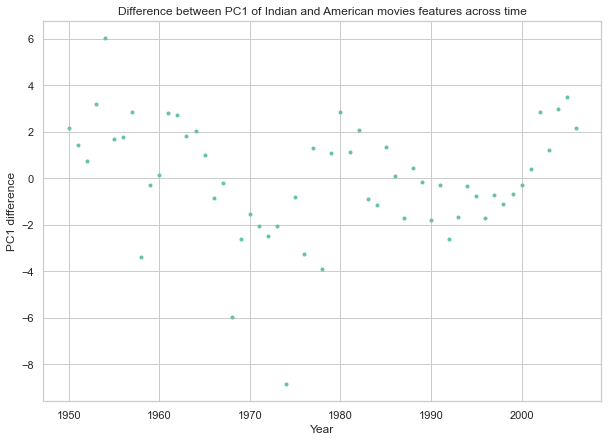

In [316]:
diff_features_year = pca.transform(features_american_year.loc[features_indian_year.index,:])[:,0] - features_indian_year_red[:,0]
plt.figure(figsize=(10,7))
plt.plot(features_indian_year.index, diff_features_year, 'o', markersize=3)
plt.title('Difference between PC1 of Indian and American movies features across time')
plt.xlabel('Year')
plt.ylabel('PC1 difference')
plt.show()

### Time series analysis with LDA

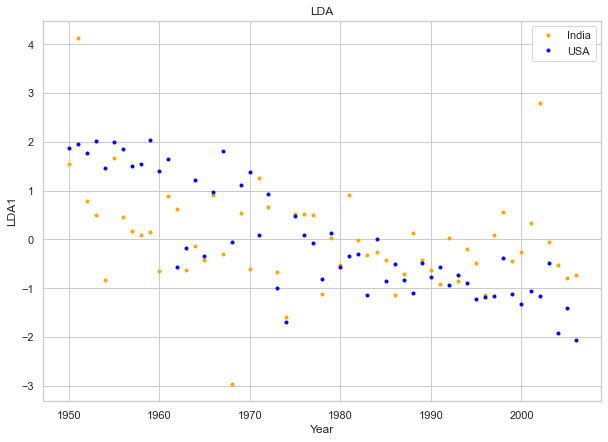

In [317]:
plt.figure(figsize=(10,7))
features_indian_year_lda = lda.transform(features_indian_year)
features_american_year_lda = lda.transform(features_american_year)
plt.plot(features_indian_year.index, features_indian_year_lda[:,0], 'o', markersize=3, c='orange', label = 'India')
plt.plot(features_american_year.index, features_american_year_lda[:,0], 'o', markersize=3, c='blue', label = 'USA')
plt.legend()
plt.title('LDA')
plt.xlabel('Year')
plt.ylabel('LDA1')
plt.show()

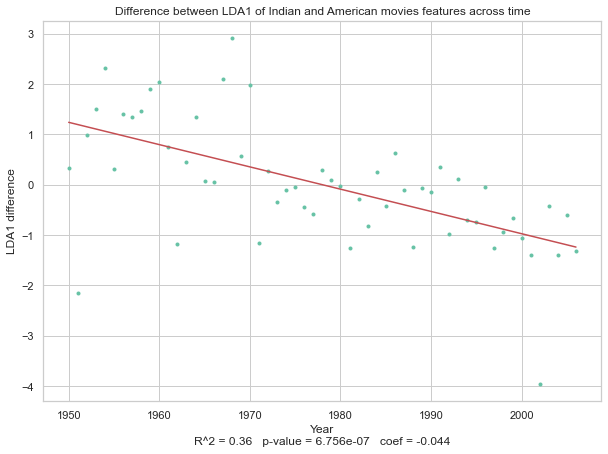

In [318]:
diff_features_year_lda = lda.transform(features_american_year.loc[features_indian_year.index,:])[:,0] - features_indian_year_lda[:,0]
lda_mod = smf.ols('diff_features_year_lda ~ features_indian_year.index', data=locals()).fit()
plt.figure(figsize=(10,7))
plt.plot(features_indian_year.index, diff_features_year_lda, 'o', markersize=3)
plt.plot(features_indian_year.index, lda_mod.predict(), 'r')
plt.xlabel('Year\nR^2 = {:.2f}   p-value = {:.3e}   coef = {:.3f}'.format(lda_mod.rsquared ,lda_mod.f_pvalue, lda_mod.params[1]))
plt.title('Difference between LDA1 of Indian and American movies features across time')
plt.ylabel('LDA1 difference')
plt.show()

## Analysis of feature importances across 3 periodes

In [322]:
#we remove this feature because it is always 0 in the indian dataset
features_indian_train.drop(columns='noir', inplace=True)
features_american_train.drop(columns='noir', inplace=True)

In [323]:
cuts = [1960, 1970, 1980, 1990, 2000, 2005]

def compute_coefs(feats, rats, cuts):
    coefs = np.zeros((len(cuts)+1, feats.shape[1]))
    counts=[sum(rats['movie_release_date'] < cuts[0])]
    svr.fit(feats.loc[rats['movie_release_date'] < cuts[0] ,:], rats.loc[rats['movie_release_date'] < cuts[0], 'averageRating'])
    coefs[0,:] = svr.coef_
    for i in range(len(cuts)-1):
        svr.fit(feats.loc[(rats['movie_release_date'] >= cuts[i]) & (rats['movie_release_date'] < cuts[i+1]) ,:], rats.loc[(rats['movie_release_date'] >= cuts[i]) & (rats['movie_release_date'] < cuts[i+1]), 'averageRating'])
        coefs[i+1,:] = svr.coef_
        counts.append(sum((rats['movie_release_date'] >= cuts[i]) & (rats['movie_release_date'] < cuts[i+1])))
    svr.fit(feats.loc[rats['movie_release_date'] >= cuts[1] ,:], rats.loc[rats['movie_release_date'] >= cuts[1], 'averageRating'])
    coefs[-1,:] = svr.coef_
    counts.append(sum(rats['movie_release_date'] >= cuts[1]))
    return coefs, counts

indian_coef, indian_counts = compute_coefs(features_indian_train, indian_ratings, cuts)
american_coef, american_counts = compute_coefs(features_american_train, american_ratings, cuts)

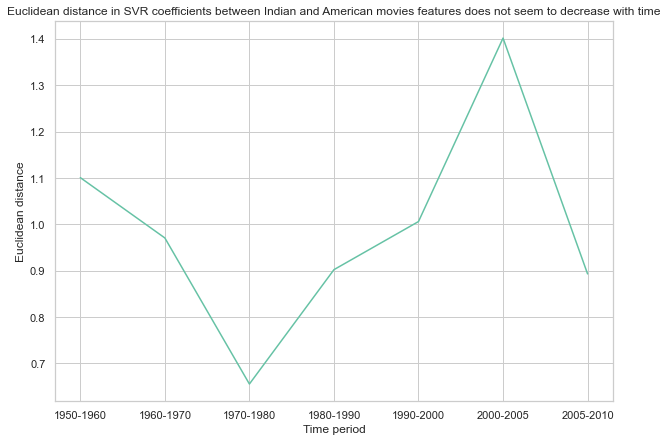

In [324]:
coef_diff = np.linalg.norm(american_coef - indian_coef, axis=1)
x = np.append('1950-'+str(cuts[0]), [str(cuts[i]) + '-' + str(cuts[i+1]) for i in range(len(cuts)-1)])
x = np.append(x, str(cuts[-1]) + '-2010')
plt.figure(figsize=(10,7))
plt.plot(x, coef_diff, markersize=3)
plt.title('Euclidean distance in SVR coefficients between Indian and American movies features does not seem to decrease with time')
plt.xlabel('Time period')
plt.ylabel('Euclidean distance')
plt.show()

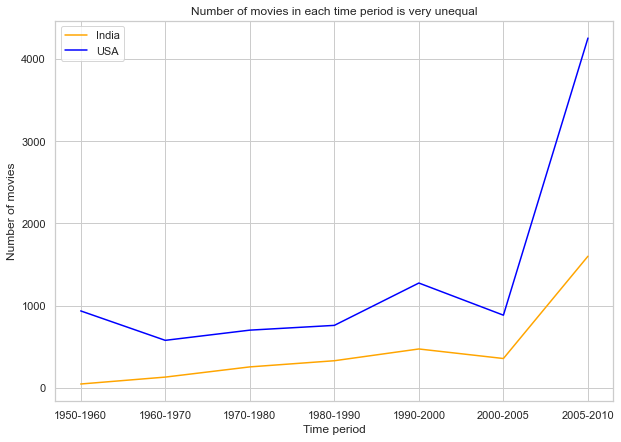

In [325]:
plt.figure(figsize=(10,7))
plt.plot(x, indian_counts, markersize=3, c='orange', label = 'India')
plt.plot(x, american_counts, markersize=3, c='blue', label = 'USA')
plt.legend()
plt.xlabel('Time period')
plt.ylabel('Number of movies')
plt.title('Number of movies in each time period is very unequal')
plt.show()

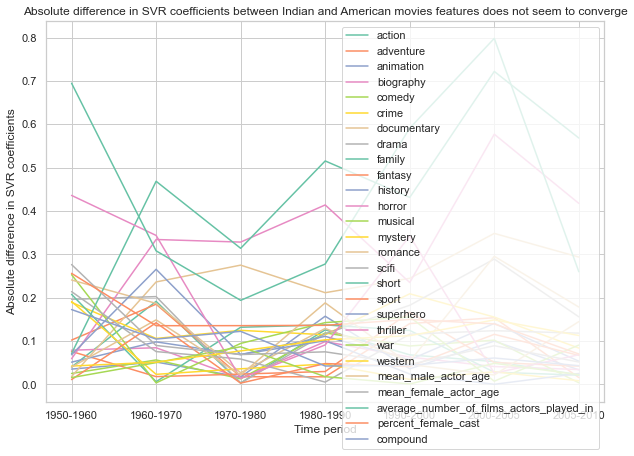

In [326]:
plt.figure(figsize=(10,7))
plt.plot(x, np.abs(indian_coef-american_coef), markersize=3, label = features_indian_train.columns)
plt.xlabel('Time period')
plt.ylabel('Absolute difference in SVR coefficients')
plt.title('Absolute difference in SVR coefficients between Indian and American movies features does not seem to converge')
plt.legend()
plt.show()